# Openclassrooms PJ6 : Categorize answers to questions :  modelisation notebook 

# Global settings

In [1]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np   
  
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy

from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_auc_score

import nltk
import codecs

#from nltk.corpus.reader.api import CorpusReader
#from nltk.corpus.reader.api import CategorizedCorpusReader

from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

import pandas_profiling

from bs4 import BeautifulSoup

DATA_PATH = os.path.join("datasets", "stackexchange")
#DATA_PATH = os.path.join(DATA_PATH, "out")

#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults_20190101-20200620.csv")
#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults 20200301-20200620_1.csv")

DATA_PATH_FILE = os.path.join(DATA_PATH, "*.csv")
ALL_FILES_LIST = glob.glob(DATA_PATH_FILE)

ALL_FEATURES = []

MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]


plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
from seaborn import boxplot
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)
'''


RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from nltk.cluster import KMeansClusterer # NLTK algorithm will be useful for cosine distance

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ6.pickle'


LEARNING_CURVE_STEP_SIZE = 100


/home/francois/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Doc2vec settings

In [2]:
DOC2VEC_TRAINING_SAVE_FILE = 'doc2vec_model'
#doc2vec_fname = get_tmpfile(DOC2VEC_TRAINING_SAVE_FILE)

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import remove_stopwords

import time

from gensim.test.utils import get_tmpfile

import gensim

#model.save(fname)
#model = Doc2Vec.load(fname)  # you can continue training with the loaded model!


In [3]:
ALL_FILES_LIST

['datasets/stackexchange/QueryResults 20190101-20190228_6.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_5.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_1.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_2.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_4.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_3.csv']

# Load data

In [4]:
import pandas as pd

pd.set_option('display.max_columns', None)

feats_list = ['Title', 'Body', 'Tags']

def load_data(data_path=DATA_PATH):
    csv_path = DATA_PATH_FILE
    df_list = []
    
    for f in ALL_FILES_LIST:
        print(f'Loading file {f}')
        
        df_list.append(pd.read_csv(f, sep=',', header=0, encoding='utf-8', usecols=feats_list))
        
    return pd.concat(df_list)


In [5]:
df = load_data()
df.reset_index(inplace=True, drop=True)

Loading file datasets/stackexchange/QueryResults 20190101-20190228_6.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_5.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_1.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_2.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_4.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_3.csv


In [6]:
df

,Body,Title,Tags
0,"<p>The <a href=""https://developer.mozilla.org/...",Is there any way to inspect ::first-line and :...,<css><developer-tools>
1,<p>I have a property injected like so:</p>\n\n...,How to track changes to the injected root inst...,<vue.js>
2,<p>so I'm trying to get this cloud query funct...,Parse Cloud Code - Await and return relation q...,<javascript><parse-server><parse-cloud>
3,<p>I need help with making some IF/OR/AND stat...,complex IF statements with multiple variables ...,<excel><if-statement><excel-formula>
4,<p>What is wrong with this filter? </p>\n\n<pr...,Active Directory userAccountcontrol multiple v...,<filter><active-directory>
...,...,...,...
299995,<p>I need to input filed value in application ...,Xpath to match case sensitive of multiple strings,<selenium><xpath><xpath-1.0>
299996,<p>I'm trying to do a basic test using Seleniu...,Using Selenium Grid to run Safari on MacOS Mojave,<java><selenium><selenium-webdriver><selenium-...
299997,"<p>Briefly, I'm parsing HTTP headers, received...","c, trimming strings, and wide characters",<c><trim><widechar><widestring>
299998,<p>Context: I'm a student who just finished an...,Operating systems vs. database management systems,<database><operating-system>


## Drop NA

In [7]:
df.dropna(subset=['Body'], axis=0, inplace=True)
df.dropna(subset=['Tags'], axis=0, inplace=True)

In [8]:
df.shape

(299144, 3)

# Encode labels (strip < and >, then 1 hot encode)

In [9]:
# Converting tags from <tag 1><tag2><tag3> to tag1 tag2 tag3
df.loc[:, 'Tags'] = df['Tags'].str.replace('<', '') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.replace('>', ' ') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.rstrip()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299144 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Body    299144 non-null  object
 1   Title   299144 non-null  object
 2   Tags    299144 non-null  object
dtypes: object(3)
memory usage: 9.1+ MB


In [11]:
#df_train.dropna(subset=['Tags'], axis=0, inplace=True)  # Can be removed later  (NA already dropped on df first place)
#df_test.dropna(subset=['Tags'], axis=0, inplace=True)  # Can be removed later  (NA already dropped on df first place)

In [12]:
bowencoder = BowEncoder()

In [13]:
bowencoder.fit(df, categorical_features_totransform=['Tags'])

BowEncoder : Fit data


BowEncoder(min_df=0.001)

In [14]:
df = bowencoder.transform(df)

BowEncoder : transform data


In [15]:
df[['Body', 'Tags', 'Tags_javascript', 'Tags_jquery', 'Tags_python', 'Tags_html', 'Tags_java', 'Tags_docker', 'Tags_android', 'Tags_cordova']]

,Body,Tags,Tags_javascript,Tags_jquery,Tags_python,Tags_html,Tags_java,Tags_docker,Tags_android,Tags_cordova
0,"<p>The <a href=""https://developer.mozilla.org/...",css developer-tools,0,0,0,0,0,0,0,0
1,<p>I have a property injected like so:</p>\n\n...,vue.js,0,0,0,0,0,0,0,0
2,<p>so I'm trying to get this cloud query funct...,javascript parse-server parse-cloud,1,0,0,0,0,0,0,0
3,<p>I need help with making some IF/OR/AND stat...,excel if-statement excel-formula,0,0,0,0,0,0,0,0
4,<p>What is wrong with this filter? </p>\n\n<pr...,filter active-directory,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
299139,<p>I need to input filed value in application ...,selenium xpath xpath-1.0,0,0,0,0,0,0,0,0
299140,<p>I'm trying to do a basic test using Seleniu...,java selenium selenium-webdriver selenium-grid...,0,0,0,0,1,0,0,0
299141,"<p>Briefly, I'm parsing HTTP headers, received...",c trim widechar widestring,0,0,0,0,0,0,0,0
299142,<p>Context: I'm a student who just finished an...,database operating-system,0,0,0,0,0,0,0,0


In [16]:
filter_col_labels = [col for col in df if col.startswith('Tags')]

In [17]:
df_labels = df[filter_col_labels].copy(deep=True)

In [18]:
df_labels.drop(columns=['Tags'], inplace=True)

In [19]:
df_labels

,Tags_.htaccess,Tags_.net,Tags_.net-core,Tags_ajax,Tags_algorithm,Tags_amazon-ec2,Tags_amazon-s3,Tags_amazon-web-services,Tags_anaconda,Tags_android,Tags_android-fragments,Tags_android-layout,Tags_android-recyclerview,Tags_android-studio,Tags_angular,Tags_angular-material,Tags_angular6,Tags_angular7,Tags_angularjs,Tags_animation,Tags_ansible,Tags_apache,Tags_apache-kafka,Tags_apache-spark,Tags_apache-spark-sql,Tags_api,Tags_arraylist,Tags_arrays,Tags_asp.net,Tags_asp.net-core,Tags_asp.net-core-mvc,Tags_asp.net-mvc,Tags_asp.net-web-api,Tags_assembly,Tags_async-await,Tags_asynchronous,Tags_authentication,Tags_automation,Tags_awk,Tags_aws-lambda,Tags_axios,Tags_azure,Tags_azure-active-directory,Tags_azure-devops,Tags_azure-functions,Tags_bash,Tags_batch-file,Tags_beautifulsoup,Tags_bootstrap-4,Tags_button,Tags_c,Tags_c#,Tags_c++,Tags_c++11,Tags_c++17,Tags_caching,Tags_canvas,Tags_class,Tags_cmake,Tags_cmd,Tags_codeigniter,Tags_cordova,Tags_css,Tags_csv,Tags_curl,Tags_d3.js,Tags_dart,Tags_data-structures,Tags_database,Tags_dataframe,Tags_datatable,Tags_datatables,Tags_date,Tags_datetime,Tags_debugging,Tags_deep-learning,Tags_delphi,Tags_dependency-injection,Tags_design-patterns,Tags_dictionary,Tags_django,Tags_django-forms,Tags_django-models,Tags_django-rest-framework,Tags_django-views,Tags_docker,Tags_docker-compose,Tags_dom,Tags_dplyr,Tags_eclipse,Tags_ecmascript-6,Tags_elasticsearch,Tags_electron,Tags_eloquent,Tags_email,Tags_encryption,Tags_entity-framework,Tags_entity-framework-core,Tags_excel,Tags_excel-formula,Tags_exception,Tags_expo,Tags_express,Tags_facebook,Tags_ffmpeg,Tags_file,Tags_filter,Tags_firebase,Tags_firebase-authentication,Tags_firebase-realtime-database,Tags_flask,Tags_flexbox,Tags_flutter,Tags_for-loop,Tags_forms,Tags_function,Tags_gcc,Tags_generics,Tags_ggplot2,Tags_git,Tags_github,Tags_gitlab,Tags_go,Tags_google-api,Tags_google-app-engine,Tags_google-apps-script,Tags_google-bigquery,Tags_google-chrome,Tags_google-chrome-extension,Tags_google-cloud-firestore,Tags_google-cloud-functions,Tags_google-cloud-platform,Tags_google-maps,Tags_google-sheets,Tags_gradle,Tags_graphql,Tags_groovy,Tags_group-by,Tags_hadoop,Tags_haskell,Tags_heroku,Tags_hibernate,Tags_highcharts,Tags_hive,Tags_html,Tags_http,Tags_https,Tags_if-statement,Tags_iis,Tags_image,Tags_image-processing,Tags_import,Tags_indexing,Tags_inheritance,Tags_input,Tags_intellij-idea,Tags_ionic-framework,Tags_ionic3,Tags_ionic4,Tags_ios,Tags_java,Tags_java-8,Tags_java-stream,Tags_javafx,Tags_javascript,Tags_jdbc,Tags_jenkins,Tags_jenkins-pipeline,Tags_jestjs,Tags_jmeter,Tags_join,Tags_jpa,Tags_jquery,Tags_json,Tags_junit,Tags_jupyter-notebook,Tags_jwt,Tags_keras,Tags_kotlin,Tags_kubernetes,Tags_lambda,Tags_laravel,Tags_laravel-5,Tags_laravel-5.7,Tags_linq,Tags_linux,Tags_list,Tags_listview,Tags_logging,Tags_loops,Tags_machine-learning,Tags_macos,Tags_mariadb,Tags_math,Tags_matlab,Tags_matplotlib,Tags_matrix,Tags_maven,Tags_memory,Tags_merge,Tags_model-view-controller,Tags_mongodb,Tags_mongoose,Tags_ms-access,Tags_multidimensional-array,Tags_multithreading,Tags_mvvm,Tags_mysql,Tags_mysqli,Tags_nativescript,Tags_neo4j,Tags_networking,Tags_neural-network,Tags_nginx,Tags_nlp,Tags_node.js,Tags_npm,Tags_numpy,Tags_oauth-2.0,Tags_object,Tags_objective-c,Tags_oop,Tags_opencv,Tags_opengl,Tags_optimization,Tags_oracle,Tags_outlook,Tags_pandas,Tags_pandas-groupby,Tags_parsing,Tags_pdf,Tags_performance,Tags_perl,Tags_php,Tags_pip,Tags_plot,Tags_plsql,Tags_pointers,Tags_post,Tags_postgresql,Tags_powerbi,Tags_powershell,Tags_promise,Tags_pycharm,Tags_pygame,Tags_pyqt5,Tags_pyspark,Tags_python,Tags_python-2.7,Tags_python-3.x,Tags_python-requests,Tags_pytorch,Tags_qt,Tags_r,Tags_random,Tags_razor,Tags_react-native,Tags_react-redux,Tags_react-router,Tags_reactjs,Tags_recursion,Tags_redis,Tags_redux,Tags_regex,Tags_rest,Tags_ruby,Tags_ruby-on-rails,Tags_ruby-on-rails-5,Tags_rust,Tags_rxjs,Tags_sass,Tags_scala,Tags_scikit-learn,Tags_scipy,Tags_scrapy,Tags_search,Tags_securit

In [20]:
df.drop(columns=filter_col_labels, inplace=True)

In [21]:
df_labels.shape

(299144, 357)

# Split training set, test set, and split labels

In [22]:
df, df_train, df_test, df_train_labels, df_test_labels = custom_train_test_split_with_labels(df, df_labels, None)

In [23]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train_labels.reset_index(drop=True, inplace=True)
df_test_labels.reset_index(drop=True, inplace=True)

In [24]:
df_train

,index,Body,Title
0,38627,<p>Here is my code:</p>\n\n<pre><code> def ...,why is my ping command getting a usage error?
1,287251,<p>Gradle sync failed when the firebase cloud ...,Gradle project sync failed. Basic functionalit...
2,55807,"<p>I have a panda dataframe with many rows, I ...",Passing second argument to function in pool.map
3,21833,"<p>I am doing a file upload page , that will r...",move_uploaded_file() failed to open stream and...
4,174456,<p>I have this piece of code located inside of...,Using Router in an interceptor located in inde...
...,...,...,...
269224,120265,<p>Can we get keys of a <code>JSON</code> in t...,Get keys of object in order?
269225,259932,<p>I am using a rich text editor to type forma...,Passing HTML string to my controller action me...
269226,132354,<h2>Problem</h2>\n<p>How do I pass a value fro...,Setting and using an environment variable in m...
269227,147325,<p>I have a C programming exam a few days late...,"Bitwise Operators in C, int 021 vs 21?"


In [25]:
df_test

,index,Body,Title
0,141549,<p>I am unable to figure out how to get to my ...,How to load website and debug node application?
1,227939,<p>Authenticate is okay when the user info is ...,How to fix unwanted exceptions from JSON.parse...
2,263961,"<pre><code>dict = {'a':['b1','b2', 'b3'], 'b':...",Library like os.path.commonprefix but returns ...
3,199225,<p>Suppose I randomly generate a list. </p>\n\...,Counting the number of times a variable has ch...
4,280078,<p>I have the following Angular template <a hr...,Angular parameter seems to have no effect in S...
...,...,...,...
29910,47530,<p>I would like to do some development with Py...,Python version for the development
29911,192379,<p>I am using micronaut 1.0.3 with Java8. I am...,Micronaut HttpClient: Correct way to handle sp...
29912,216130,<p>we are making an VR experience and we have ...,Unity VR can't see textures on build
29913,185830,<p>I am trying to use urllib to fill out a for...,"sending data, but result shows a GET request i..."


In [26]:
df_train_labels

,Tags_.htaccess,Tags_.net,Tags_.net-core,Tags_ajax,Tags_algorithm,Tags_amazon-ec2,Tags_amazon-s3,Tags_amazon-web-services,Tags_anaconda,Tags_android,Tags_android-fragments,Tags_android-layout,Tags_android-recyclerview,Tags_android-studio,Tags_angular,Tags_angular-material,Tags_angular6,Tags_angular7,Tags_angularjs,Tags_animation,Tags_ansible,Tags_apache,Tags_apache-kafka,Tags_apache-spark,Tags_apache-spark-sql,Tags_api,Tags_arraylist,Tags_arrays,Tags_asp.net,Tags_asp.net-core,Tags_asp.net-core-mvc,Tags_asp.net-mvc,Tags_asp.net-web-api,Tags_assembly,Tags_async-await,Tags_asynchronous,Tags_authentication,Tags_automation,Tags_awk,Tags_aws-lambda,Tags_axios,Tags_azure,Tags_azure-active-directory,Tags_azure-devops,Tags_azure-functions,Tags_bash,Tags_batch-file,Tags_beautifulsoup,Tags_bootstrap-4,Tags_button,Tags_c,Tags_c#,Tags_c++,Tags_c++11,Tags_c++17,Tags_caching,Tags_canvas,Tags_class,Tags_cmake,Tags_cmd,Tags_codeigniter,Tags_cordova,Tags_css,Tags_csv,Tags_curl,Tags_d3.js,Tags_dart,Tags_data-structures,Tags_database,Tags_dataframe,Tags_datatable,Tags_datatables,Tags_date,Tags_datetime,Tags_debugging,Tags_deep-learning,Tags_delphi,Tags_dependency-injection,Tags_design-patterns,Tags_dictionary,Tags_django,Tags_django-forms,Tags_django-models,Tags_django-rest-framework,Tags_django-views,Tags_docker,Tags_docker-compose,Tags_dom,Tags_dplyr,Tags_eclipse,Tags_ecmascript-6,Tags_elasticsearch,Tags_electron,Tags_eloquent,Tags_email,Tags_encryption,Tags_entity-framework,Tags_entity-framework-core,Tags_excel,Tags_excel-formula,Tags_exception,Tags_expo,Tags_express,Tags_facebook,Tags_ffmpeg,Tags_file,Tags_filter,Tags_firebase,Tags_firebase-authentication,Tags_firebase-realtime-database,Tags_flask,Tags_flexbox,Tags_flutter,Tags_for-loop,Tags_forms,Tags_function,Tags_gcc,Tags_generics,Tags_ggplot2,Tags_git,Tags_github,Tags_gitlab,Tags_go,Tags_google-api,Tags_google-app-engine,Tags_google-apps-script,Tags_google-bigquery,Tags_google-chrome,Tags_google-chrome-extension,Tags_google-cloud-firestore,Tags_google-cloud-functions,Tags_google-cloud-platform,Tags_google-maps,Tags_google-sheets,Tags_gradle,Tags_graphql,Tags_groovy,Tags_group-by,Tags_hadoop,Tags_haskell,Tags_heroku,Tags_hibernate,Tags_highcharts,Tags_hive,Tags_html,Tags_http,Tags_https,Tags_if-statement,Tags_iis,Tags_image,Tags_image-processing,Tags_import,Tags_indexing,Tags_inheritance,Tags_input,Tags_intellij-idea,Tags_ionic-framework,Tags_ionic3,Tags_ionic4,Tags_ios,Tags_java,Tags_java-8,Tags_java-stream,Tags_javafx,Tags_javascript,Tags_jdbc,Tags_jenkins,Tags_jenkins-pipeline,Tags_jestjs,Tags_jmeter,Tags_join,Tags_jpa,Tags_jquery,Tags_json,Tags_junit,Tags_jupyter-notebook,Tags_jwt,Tags_keras,Tags_kotlin,Tags_kubernetes,Tags_lambda,Tags_laravel,Tags_laravel-5,Tags_laravel-5.7,Tags_linq,Tags_linux,Tags_list,Tags_listview,Tags_logging,Tags_loops,Tags_machine-learning,Tags_macos,Tags_mariadb,Tags_math,Tags_matlab,Tags_matplotlib,Tags_matrix,Tags_maven,Tags_memory,Tags_merge,Tags_model-view-controller,Tags_mongodb,Tags_mongoose,Tags_ms-access,Tags_multidimensional-array,Tags_multithreading,Tags_mvvm,Tags_mysql,Tags_mysqli,Tags_nativescript,Tags_neo4j,Tags_networking,Tags_neural-network,Tags_nginx,Tags_nlp,Tags_node.js,Tags_npm,Tags_numpy,Tags_oauth-2.0,Tags_object,Tags_objective-c,Tags_oop,Tags_opencv,Tags_opengl,Tags_optimization,Tags_oracle,Tags_outlook,Tags_pandas,Tags_pandas-groupby,Tags_parsing,Tags_pdf,Tags_performance,Tags_perl,Tags_php,Tags_pip,Tags_plot,Tags_plsql,Tags_pointers,Tags_post,Tags_postgresql,Tags_powerbi,Tags_powershell,Tags_promise,Tags_pycharm,Tags_pygame,Tags_pyqt5,Tags_pyspark,Tags_python,Tags_python-2.7,Tags_python-3.x,Tags_python-requests,Tags_pytorch,Tags_qt,Tags_r,Tags_random,Tags_razor,Tags_react-native,Tags_react-redux,Tags_react-router,Tags_reactjs,Tags_recursion,Tags_redis,Tags_redux,Tags_regex,Tags_rest,Tags_ruby,Tags_ruby-on-rails,Tags_ruby-on-rails-5,Tags_rust,Tags_rxjs,Tags_sass,Tags_scala,Tags_scikit-learn,Tags_scipy,Tags_scrapy,Tags_search,Tags_securit

In [27]:
df_test_labels

,Tags_.htaccess,Tags_.net,Tags_.net-core,Tags_ajax,Tags_algorithm,Tags_amazon-ec2,Tags_amazon-s3,Tags_amazon-web-services,Tags_anaconda,Tags_android,Tags_android-fragments,Tags_android-layout,Tags_android-recyclerview,Tags_android-studio,Tags_angular,Tags_angular-material,Tags_angular6,Tags_angular7,Tags_angularjs,Tags_animation,Tags_ansible,Tags_apache,Tags_apache-kafka,Tags_apache-spark,Tags_apache-spark-sql,Tags_api,Tags_arraylist,Tags_arrays,Tags_asp.net,Tags_asp.net-core,Tags_asp.net-core-mvc,Tags_asp.net-mvc,Tags_asp.net-web-api,Tags_assembly,Tags_async-await,Tags_asynchronous,Tags_authentication,Tags_automation,Tags_awk,Tags_aws-lambda,Tags_axios,Tags_azure,Tags_azure-active-directory,Tags_azure-devops,Tags_azure-functions,Tags_bash,Tags_batch-file,Tags_beautifulsoup,Tags_bootstrap-4,Tags_button,Tags_c,Tags_c#,Tags_c++,Tags_c++11,Tags_c++17,Tags_caching,Tags_canvas,Tags_class,Tags_cmake,Tags_cmd,Tags_codeigniter,Tags_cordova,Tags_css,Tags_csv,Tags_curl,Tags_d3.js,Tags_dart,Tags_data-structures,Tags_database,Tags_dataframe,Tags_datatable,Tags_datatables,Tags_date,Tags_datetime,Tags_debugging,Tags_deep-learning,Tags_delphi,Tags_dependency-injection,Tags_design-patterns,Tags_dictionary,Tags_django,Tags_django-forms,Tags_django-models,Tags_django-rest-framework,Tags_django-views,Tags_docker,Tags_docker-compose,Tags_dom,Tags_dplyr,Tags_eclipse,Tags_ecmascript-6,Tags_elasticsearch,Tags_electron,Tags_eloquent,Tags_email,Tags_encryption,Tags_entity-framework,Tags_entity-framework-core,Tags_excel,Tags_excel-formula,Tags_exception,Tags_expo,Tags_express,Tags_facebook,Tags_ffmpeg,Tags_file,Tags_filter,Tags_firebase,Tags_firebase-authentication,Tags_firebase-realtime-database,Tags_flask,Tags_flexbox,Tags_flutter,Tags_for-loop,Tags_forms,Tags_function,Tags_gcc,Tags_generics,Tags_ggplot2,Tags_git,Tags_github,Tags_gitlab,Tags_go,Tags_google-api,Tags_google-app-engine,Tags_google-apps-script,Tags_google-bigquery,Tags_google-chrome,Tags_google-chrome-extension,Tags_google-cloud-firestore,Tags_google-cloud-functions,Tags_google-cloud-platform,Tags_google-maps,Tags_google-sheets,Tags_gradle,Tags_graphql,Tags_groovy,Tags_group-by,Tags_hadoop,Tags_haskell,Tags_heroku,Tags_hibernate,Tags_highcharts,Tags_hive,Tags_html,Tags_http,Tags_https,Tags_if-statement,Tags_iis,Tags_image,Tags_image-processing,Tags_import,Tags_indexing,Tags_inheritance,Tags_input,Tags_intellij-idea,Tags_ionic-framework,Tags_ionic3,Tags_ionic4,Tags_ios,Tags_java,Tags_java-8,Tags_java-stream,Tags_javafx,Tags_javascript,Tags_jdbc,Tags_jenkins,Tags_jenkins-pipeline,Tags_jestjs,Tags_jmeter,Tags_join,Tags_jpa,Tags_jquery,Tags_json,Tags_junit,Tags_jupyter-notebook,Tags_jwt,Tags_keras,Tags_kotlin,Tags_kubernetes,Tags_lambda,Tags_laravel,Tags_laravel-5,Tags_laravel-5.7,Tags_linq,Tags_linux,Tags_list,Tags_listview,Tags_logging,Tags_loops,Tags_machine-learning,Tags_macos,Tags_mariadb,Tags_math,Tags_matlab,Tags_matplotlib,Tags_matrix,Tags_maven,Tags_memory,Tags_merge,Tags_model-view-controller,Tags_mongodb,Tags_mongoose,Tags_ms-access,Tags_multidimensional-array,Tags_multithreading,Tags_mvvm,Tags_mysql,Tags_mysqli,Tags_nativescript,Tags_neo4j,Tags_networking,Tags_neural-network,Tags_nginx,Tags_nlp,Tags_node.js,Tags_npm,Tags_numpy,Tags_oauth-2.0,Tags_object,Tags_objective-c,Tags_oop,Tags_opencv,Tags_opengl,Tags_optimization,Tags_oracle,Tags_outlook,Tags_pandas,Tags_pandas-groupby,Tags_parsing,Tags_pdf,Tags_performance,Tags_perl,Tags_php,Tags_pip,Tags_plot,Tags_plsql,Tags_pointers,Tags_post,Tags_postgresql,Tags_powerbi,Tags_powershell,Tags_promise,Tags_pycharm,Tags_pygame,Tags_pyqt5,Tags_pyspark,Tags_python,Tags_python-2.7,Tags_python-3.x,Tags_python-requests,Tags_pytorch,Tags_qt,Tags_r,Tags_random,Tags_razor,Tags_react-native,Tags_react-redux,Tags_react-router,Tags_reactjs,Tags_recursion,Tags_redis,Tags_redux,Tags_regex,Tags_rest,Tags_ruby,Tags_ruby-on-rails,Tags_ruby-on-rails-5,Tags_rust,Tags_rxjs,Tags_sass,Tags_scala,Tags_scikit-learn,Tags_scipy,Tags_scrapy,Tags_search,Tags_securit

In [28]:
df_train_ori = df_train.copy(deep=True)
df_test_ori = df_test.copy(deep=True)

df_train_labels_ori = df_train_labels.copy(deep=True)
df_test_labels_ori = df_test_labels.copy(deep=True)

In [29]:
df_train.shape

(269229, 3)

In [30]:
df_test.shape

(29915, 3)

In [31]:
df_train_labels.shape

(269229, 357)

In [32]:
df_test_labels.shape

(29915, 357)

# Prepare text data (remove html in Body, and regroup Body + title)

In [33]:
df_train = df_train_ori
df_test = df_test_ori

In [34]:
dataprep = PrepareTextData()

In [35]:
df_train = dataprep.fit_transform(df_train)

PrepareTextData : Fit data
PrepareTextData : Transform data


In [36]:
df_test = dataprep.transform(df_test)

PrepareTextData : Transform data


In [37]:
df_train

,all_text
0,why is my ping command getting a usage error?....
1,Gradle project sync failed. Basic functionalit...
2,Passing second argument to function in pool.ma...
3,move_uploaded_file() failed to open stream and...
4,Using Router in an interceptor located in inde...
...,...
269224,Get keys of object in order?. Can we get keys ...
269225,Passing HTML string to my controller action me...
269226,Setting and using an environment variable in m...
269227,"Bitwise Operators in C, int 021 vs 21?. I have..."


In [38]:
df_test

,all_text
0,How to load website and debug node application...
1,How to fix unwanted exceptions from JSON.parse...
2,Library like os.path.commonprefix but returns ...
3,Counting the number of times a variable has ch...
4,Angular parameter seems to have no effect in S...
...,...
29910,Python version for the development. I would li...
29911,Micronaut HttpClient: Correct way to handle sp...
29912,Unity VR can't see textures on build. we are m...
29913,"sending data, but result shows a GET request i..."


# Doc2Vec training (launch only the 1st time)

In [ ]:
cnt_label = 0
InputDocs = []
for document in df_train['all_text']:  # TO DO : relaunch this training with df_train
    #InputDocs.append(TaggedDocument(document,[cnt_label]))
    
    doc_transformed = remove_stopwords(document)
    doc_toappend = gensim.utils.simple_preprocess(doc_transformed)
    
    InputDocs.append(TaggedDocument(doc_toappend,[cnt_label]))    
    cnt_label += 1

In [ ]:
InputDocs

In [69]:
start = time.time()
model_doc2vec = Doc2Vec(InputDocs, vector_size=200, window=5, min_count=5, workers=4)  # All input docs loaded in memory
end = time.time()

print('Durée doc2vec training: ' + str(end - start) + ' secondes')    

Durée doc2vec training: 398.01753854751587 secondes


In [70]:
#model_doc2vec.save(doc2vec_fname)
model_doc2vec.save(DOC2VEC_TRAINING_SAVE_FILE)

In [71]:
TaggedDocument(gensim.utils.simple_preprocess(df_train.iloc[0]['all_text']), [0])

TaggedDocument(words=['why', 'is', 'my', 'ping', 'command', 'getting', 'usage', 'error', 'here', 'is', 'my', 'code', 'def', 'ping_host', 'self', 'hostname', 'ping_cmd', 'usr', 'bin', 'ping', 'count', 'timeout', 'cmd', 'ping_cmd', 'count', 'timeout', 'hostname', 'output', 'error', 'subprocess', 'popen', 'cmd', 'stdout', 'subprocess', 'pipe', 'stderr', 'subprocess', 'pipe', 'shell', 'true', 'communicate', 'print', 'join', 'cmd', 'print', 'output', 'error', 'when', 'run', 'it', 'get', 'this', 'output', 'usr', 'bin', 'ping', 'tools', 'dev', 'example', 'com', 'usage', 'ping', 'count', 'interval', 'interface', 'mark', 'pmtudisc_option', 'preload', 'pattern', 'tos', 'packetsize', 'sndbuf', 'ttl', 'deadline', 'timeout', 'hop', 'destination', 'usage', 'ping', 'count', 'interval', 'interface', 'preload', 'mark', 'pmtudisc_option', 'nodeinfo_option', 'pattern', 'tclass', 'packetsize', 'sndbuf', 'ttl', 'deadline', 'timeout', 'destination', 'assume', 'am', 'doing', 'something', 'wrong', 'with', 'th

In [72]:
gensim.utils.simple_preprocess("Hello this is a new text")

['hello', 'this', 'is', 'new', 'text']

In [73]:
[model_doc2vec.infer_vector(gensim.utils.simple_preprocess(text)) for text in ['hello this is', 'second text']]

[array([ 2.09137686e-02, -2.18940945e-03, -1.14140874e-02, -1.19561749e-02,
        -1.47045255e-02, -3.04870494e-02, -3.55851860e-03, -9.83100617e-04,
         3.51592638e-02, -3.67193632e-02,  1.71000685e-03, -2.77323201e-02,
         6.46899315e-03, -9.48780309e-03,  6.24315767e-03,  4.14009346e-03,
        -4.19779727e-03,  9.38487519e-03,  1.15454039e-02, -2.60294098e-02,
        -3.43055241e-02,  2.09935773e-02, -9.65382345e-03,  4.04058862e-03,
         1.13382665e-02,  1.06888246e-02, -1.92741621e-02, -2.02421267e-02,
         1.04010869e-02,  3.09562236e-02, -1.90024003e-02, -2.03841217e-02,
         4.04751394e-03, -1.59872733e-02,  3.55172646e-03, -5.51851131e-02,
         1.64682362e-02, -1.89960748e-02,  1.68417615e-03,  7.66108138e-03,
         2.49439757e-03, -7.54581764e-03, -8.38271063e-03,  2.01061945e-02,
        -1.95211396e-02, -8.72576144e-03, -9.51920578e-04,  4.85786796e-03,
         7.32369674e-03, -9.52586625e-03, -1.53034301e-02, -1.08128944e-02,
         1.4

In [49]:
#a = [document for document in df_train.loc[:,'all_text'] ] 

In [51]:
#df_train.shape

(269928, 5)

In [50]:
#len(a)

269928

In [74]:
#X_vectorized = [model_doc2vec.infer_vector(TaggedDocument(document)) for document in df_train.loc[:, 'all_text']]  # Too slow on training set

In [76]:
#X_vectorized

# Doc2vec loading

In [ ]:
df_train = df_train_ori
df_test = df_test_ori

In [ ]:
df

In [ ]:
from functions import *
importlib.reload(sys.modules['functions'])
from functions import *

In [ ]:
doc2vec = Doc2Vec_Vectorizer(model_path=DOC2VEC_TRAINING_SAVE_FILE, feature_totransform='all_text')

In [ ]:
doc2vec.fit(df_train)

In [ ]:
doc2vec.model.docvecs.vectors_docs

In [45]:
# Use this to infer vectors :  needed for test set, but not mandatory for training set (we alredy have trained vectors available)
#df_train_transformed = doc2vec.transform(df_train.loc[0:1000, :])
#df_train_transformed = doc2vec.transform(df_train)

# Use this to get already trained vectors in training set
df_train_transformed = doc2vec.model.docvecs.vectors_docs

In [46]:
df_train_transformed.shape

(269229, 200)

In [47]:
df_train_transformed

array([[-0.07071376,  0.10523795, -0.08744038, ..., -0.11130399,
        -0.02079851,  0.00495762],
       [ 0.03320783,  0.06237803, -0.01782712, ...,  0.07693912,
         0.00665112, -0.01528825],
       [-0.07552645,  0.07234379,  0.03901878, ...,  0.01188631,
        -0.02476238,  0.04396393],
       ...,
       [ 0.14574856,  0.05162671,  0.01735994, ..., -0.11106838,
        -0.14130326, -0.0831008 ],
       [ 0.05304777, -0.02145692, -0.02539402, ..., -0.00840256,
         0.07861464, -0.08402767],
       [ 0.02249722,  0.08344096,  0.00879873, ..., -0.0926139 ,
        -0.22885188,  0.04260959]], dtype=float32)

In [48]:
df_train = df_train_transformed

# First clustering attempts (launch only once)

In [39]:
df_train.shape

(269229, 1)

In [40]:
df_train_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269229 entries, 0 to 269228
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     269229 non-null  int64 
 1   Body      269229 non-null  object
 2   Title     269229 non-null  object
 3   all_text  269229 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.2+ MB


In [41]:
df_train

,all_text
0,why is my ping command getting a usage error?....
1,Gradle project sync failed. Basic functionalit...
2,Passing second argument to function in pool.ma...
3,move_uploaded_file() failed to open stream and...
4,Using Router in an interceptor located in inde...
...,...
269224,Get keys of object in order?. Can we get keys ...
269225,Passing HTML string to my controller action me...
269226,Setting and using an environment variable in m...
269227,"Bitwise Operators in C, int 021 vs 21?. I have..."


In [34]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 20)]

In [39]:
'''
kmeans_model_nltk = KMeansClusterer(
            10, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True, repeats=10) 
'''

'\nkmeans_model_nltk = KMeansClusterer(\n            10, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True, repeats=10) \n'

In [40]:
'''
clusters = kmeans_model_nltk.cluster(df_train.to_numpy(), assign_clusters = True)    
'''

'\nclusters = kmeans_model_nltk.cluster(df_train.to_numpy(), assign_clusters = True)    \n'

In [41]:
kmeans_nltk_per_k = [KMeansClusterer(
            k, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True, repeats=10) for k in range(1,20)]

In [ ]:
# If df_train is a dataframe  (when vectors have been infered) :
#kmeans_nltk_labels_train_per_k = [model.cluster(df_train.to_numpy(), assign_clusters = True) for model in kmeans_nltk_per_k]

# If df_train is an ndarray (when we directly got training labels):
kmeans_nltk_labels_train_per_k = [model.cluster(df_train, assign_clusters = True) for model in kmeans_nltk_per_k]

In [ ]:
#labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [35]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
silhouette_scores_nltk = [silhouette_score(df_train, labels)
                     for labels in kmeans_nltk_labels_train_per_k[1:]]

In [247]:
#silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

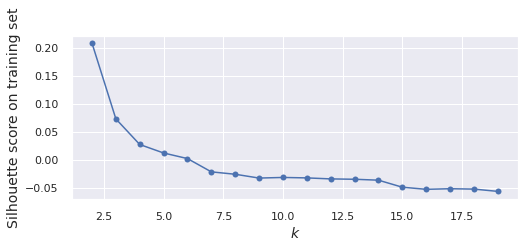

In [36]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores_nltk, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score of KMeans NLTK (with cosine distance) on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Compare 1 document to closest neighbours

In [48]:
df_train_ori

,index,Body,Title,all_text
0,38627,"Here is my code:\n def ping_host(self, host...",why is my ping command getting a usage error?,why is my ping command getting a usage error?....
1,287251,Gradle sync failed when the firebase cloud mes...,Gradle project sync failed. Basic functionalit...,Gradle project sync failed. Basic functionalit...
2,55807,"I have a panda dataframe with many rows, I am ...",Passing second argument to function in pool.map,Passing second argument to function in pool.ma...
3,21833,"I am doing a file upload page , that will rena...",move_uploaded_file() failed to open stream and...,move_uploaded_file() failed to open stream and...
4,174456,I have this piece of code located inside of th...,Using Router in an interceptor located in inde...,Using Router in an interceptor located in inde...
...,...,...,...,...
269224,120265,Can we get keys of a JSON in the same order it...,Get keys of object in order?,Get keys of object in order?. Can we get keys ...
269225,259932,I am using a rich text editor to type formatte...,Passing HTML string to my controller action me...,Passing HTML string to my controller action me...
269226,132354,Problem\nHow do I pass a value from a release ...,Setting and using an environment variable in m...,Setting and using an environment variable in m...
269227,147325,"I have a C programming exam a few days later, ...","Bitwise Operators in C, int 021 vs 21?","Bitwise Operators in C, int 021 vs 21?. I have..."


In [49]:
df_train.shape

(269229, 4)

In [50]:
df_train_ori.shape

(269229, 4)

In [122]:
doc_to_compare = df_train_ori.loc[1000]['Body']

In [123]:
print(doc_to_compare)

<?php
    $str = "xyz@gmail.com";
    $username = strstr($str, '@', true);
    echo $username;
?>

I want to remove sender name before @ tag and output should be @gmail.com. Now,  It shows me xyz output which I don't want. So, How can I do this? Please help me.
I want to output @gmail.com.



In [124]:
doc2vec.model.docvecs.most_similar([doc2vec.model.infer_vector(gensim.utils.simple_preprocess(remove_stopwords(doc_to_compare)))])

[(1000, 0.7409844398498535),
 (147035, 0.47345641255378723),
 (52968, 0.45012423396110535),
 (197221, 0.4367449879646301),
 (187104, 0.43562090396881104),
 (94276, 0.42392751574516296),
 (163205, 0.4231509566307068),
 (119275, 0.4181053638458252),
 (110681, 0.4168698191642761),
 (79968, 0.41466009616851807)]

In [125]:
doc_ids = [doc[0] for doc in doc2vec.model.docvecs.most_similar([doc2vec.model.infer_vector(gensim.utils.simple_preprocess(remove_stopwords(doc_to_compare)))])]

In [126]:
doc_ids_str = [str(doc_id) for doc_id in doc_ids]

In [127]:
doc_ids_str

['1000',
 '119275',
 '130575',
 '147035',
 '52968',
 '110681',
 '163205',
 '197221',
 '3669',
 '94276']

In [128]:
col_names_with_value_1 = [col for col in df_train_labels[df_train_labels.index.isin(doc_ids_str)]\
                          if (df_train_labels[df_train_labels.index.isin(doc_ids_str)][col] == 1).any()]

In [129]:
df_train_labels[df_train_labels.index.isin(doc_ids_str)]\
    .loc[:,col_names_with_value_1]

,Tags_arrays,Tags_file,Tags_firebase,Tags_google-cloud-functions,Tags_google-cloud-platform,Tags_heroku,Tags_laravel,Tags_macos,Tags_php,Tags_python,Tags_regex,Tags_string,Tags_windows
1000,0,0,0,0,0,0,0,0,1,0,0,0,0
3669,0,0,0,0,0,0,0,0,1,0,0,0,0
52968,1,0,0,0,0,0,0,0,1,0,0,1,0
94276,0,0,1,1,1,0,0,0,1,0,0,0,0
110681,0,0,0,0,0,0,0,0,1,0,0,1,0
119275,0,0,0,0,0,1,1,0,1,0,0,0,1
130575,0,0,0,0,0,0,0,0,0,1,0,0,0
147035,0,1,0,0,0,0,0,0,1,0,1,0,0
163205,0,0,0,0,0,0,0,1,0,0,0,0,0
197221,0,0,0,0,0,0,0,0,1,0,1,0,0


# First implementation of a KNN classification algorithm

In [39]:
importlib.reload(sys.modules['functions'])
from functions import *

In [40]:
df_train = df_train_ori
df_test = df_test_ori

df_train_labels = df_train_labels_ori
df_test_labels = df_test_labels_ori

In [41]:
'''
df_train = df_train.loc[0:1000, :]
df_train_labels = df_train_labels.loc[0:1000, :]
'''

'\ndf_train = df_train.loc[0:1000, :]\ndf_train_labels = df_train_labels.loc[0:1000, :]\n'

In [42]:
df_train

,index,Body,Title,all_text
0,38627,"Here is my code:\n def ping_host(self, host...",why is my ping command getting a usage error?,why is my ping command getting a usage error?....
1,287251,Gradle sync failed when the firebase cloud mes...,Gradle project sync failed. Basic functionalit...,Gradle project sync failed. Basic functionalit...
2,55807,"I have a panda dataframe with many rows, I am ...",Passing second argument to function in pool.map,Passing second argument to function in pool.ma...
3,21833,"I am doing a file upload page , that will rena...",move_uploaded_file() failed to open stream and...,move_uploaded_file() failed to open stream and...
4,174456,I have this piece of code located inside of th...,Using Router in an interceptor located in inde...,Using Router in an interceptor located in inde...
...,...,...,...,...
269224,120265,Can we get keys of a JSON in the same order it...,Get keys of object in order?,Get keys of object in order?. Can we get keys ...
269225,259932,I am using a rich text editor to type formatte...,Passing HTML string to my controller action me...,Passing HTML string to my controller action me...
269226,132354,Problem\nHow do I pass a value from a release ...,Setting and using an environment variable in m...,Setting and using an environment variable in m...
269227,147325,"I have a C programming exam a few days later, ...","Bitwise Operators in C, int 021 vs 21?","Bitwise Operators in C, int 021 vs 21?. I have..."


In [43]:
prediction_pipeline = Pipeline([
    ('doc2vec', Doc2Vec_Vectorizer(model_path=DOC2VEC_TRAINING_SAVE_FILE, feature_totransform='all_text')),
    #('features_selector', FeaturesSelector(features_toselect=['Tags'])),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(),)
    ])

In [44]:
prediction_pipeline.fit(df_train, df_train_labels)

Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Returning stored vectors from training set


Pipeline(memory=None,
         steps=[('doc2vec',
                 Doc2Vec_Vectorizer(feature_totransform='all_text', min_count=5,
                                    model_path='doc2vec_model',
                                    model_save_path=None, n_dim=200,
                                    remove_stopwords=None, window=5)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [55]:
predictions_train = prediction_pipeline.predict(df_train)

Transform Doc2vec_Vectorizer
Returning stored vectors from training set


In [56]:
df_predictions_train = pd.DataFrame(predictions_train, columns=df_train_labels.columns)

In [45]:
predictions_test = prediction_pipeline.predict(df_test)

Transform Doc2vec_Vectorizer
Infering new vectors


In [46]:
df_predictions_test = pd.DataFrame(predictions_test, columns=df_test_labels.columns)

In [57]:
df_predictions_train

,Tags_.htaccess,Tags_.net,Tags_.net-core,Tags_ajax,Tags_algorithm,Tags_amazon-ec2,Tags_amazon-s3,Tags_amazon-web-services,Tags_anaconda,Tags_android,Tags_android-fragments,Tags_android-layout,Tags_android-recyclerview,Tags_android-studio,Tags_angular,Tags_angular-material,Tags_angular6,Tags_angular7,Tags_angularjs,Tags_animation,Tags_ansible,Tags_apache,Tags_apache-kafka,Tags_apache-spark,Tags_apache-spark-sql,Tags_api,Tags_arraylist,Tags_arrays,Tags_asp.net,Tags_asp.net-core,Tags_asp.net-core-mvc,Tags_asp.net-mvc,Tags_asp.net-web-api,Tags_assembly,Tags_async-await,Tags_asynchronous,Tags_authentication,Tags_automation,Tags_awk,Tags_aws-lambda,Tags_axios,Tags_azure,Tags_azure-active-directory,Tags_azure-devops,Tags_azure-functions,Tags_bash,Tags_batch-file,Tags_beautifulsoup,Tags_bootstrap-4,Tags_button,Tags_c,Tags_c#,Tags_c++,Tags_c++11,Tags_c++17,Tags_caching,Tags_canvas,Tags_class,Tags_cmake,Tags_cmd,Tags_codeigniter,Tags_cordova,Tags_css,Tags_csv,Tags_curl,Tags_d3.js,Tags_dart,Tags_data-structures,Tags_database,Tags_dataframe,Tags_datatable,Tags_datatables,Tags_date,Tags_datetime,Tags_debugging,Tags_deep-learning,Tags_delphi,Tags_dependency-injection,Tags_design-patterns,Tags_dictionary,Tags_django,Tags_django-forms,Tags_django-models,Tags_django-rest-framework,Tags_django-views,Tags_docker,Tags_docker-compose,Tags_dom,Tags_dplyr,Tags_eclipse,Tags_ecmascript-6,Tags_elasticsearch,Tags_electron,Tags_eloquent,Tags_email,Tags_encryption,Tags_entity-framework,Tags_entity-framework-core,Tags_excel,Tags_excel-formula,Tags_exception,Tags_expo,Tags_express,Tags_facebook,Tags_ffmpeg,Tags_file,Tags_filter,Tags_firebase,Tags_firebase-authentication,Tags_firebase-realtime-database,Tags_flask,Tags_flexbox,Tags_flutter,Tags_for-loop,Tags_forms,Tags_function,Tags_gcc,Tags_generics,Tags_ggplot2,Tags_git,Tags_github,Tags_gitlab,Tags_go,Tags_google-api,Tags_google-app-engine,Tags_google-apps-script,Tags_google-bigquery,Tags_google-chrome,Tags_google-chrome-extension,Tags_google-cloud-firestore,Tags_google-cloud-functions,Tags_google-cloud-platform,Tags_google-maps,Tags_google-sheets,Tags_gradle,Tags_graphql,Tags_groovy,Tags_group-by,Tags_hadoop,Tags_haskell,Tags_heroku,Tags_hibernate,Tags_highcharts,Tags_hive,Tags_html,Tags_http,Tags_https,Tags_if-statement,Tags_iis,Tags_image,Tags_image-processing,Tags_import,Tags_indexing,Tags_inheritance,Tags_input,Tags_intellij-idea,Tags_ionic-framework,Tags_ionic3,Tags_ionic4,Tags_ios,Tags_java,Tags_java-8,Tags_java-stream,Tags_javafx,Tags_javascript,Tags_jdbc,Tags_jenkins,Tags_jenkins-pipeline,Tags_jestjs,Tags_jmeter,Tags_join,Tags_jpa,Tags_jquery,Tags_json,Tags_junit,Tags_jupyter-notebook,Tags_jwt,Tags_keras,Tags_kotlin,Tags_kubernetes,Tags_lambda,Tags_laravel,Tags_laravel-5,Tags_laravel-5.7,Tags_linq,Tags_linux,Tags_list,Tags_listview,Tags_logging,Tags_loops,Tags_machine-learning,Tags_macos,Tags_mariadb,Tags_math,Tags_matlab,Tags_matplotlib,Tags_matrix,Tags_maven,Tags_memory,Tags_merge,Tags_model-view-controller,Tags_mongodb,Tags_mongoose,Tags_ms-access,Tags_multidimensional-array,Tags_multithreading,Tags_mvvm,Tags_mysql,Tags_mysqli,Tags_nativescript,Tags_neo4j,Tags_networking,Tags_neural-network,Tags_nginx,Tags_nlp,Tags_node.js,Tags_npm,Tags_numpy,Tags_oauth-2.0,Tags_object,Tags_objective-c,Tags_oop,Tags_opencv,Tags_opengl,Tags_optimization,Tags_oracle,Tags_outlook,Tags_pandas,Tags_pandas-groupby,Tags_parsing,Tags_pdf,Tags_performance,Tags_perl,Tags_php,Tags_pip,Tags_plot,Tags_plsql,Tags_pointers,Tags_post,Tags_postgresql,Tags_powerbi,Tags_powershell,Tags_promise,Tags_pycharm,Tags_pygame,Tags_pyqt5,Tags_pyspark,Tags_python,Tags_python-2.7,Tags_python-3.x,Tags_python-requests,Tags_pytorch,Tags_qt,Tags_r,Tags_random,Tags_razor,Tags_react-native,Tags_react-redux,Tags_react-router,Tags_reactjs,Tags_recursion,Tags_redis,Tags_redux,Tags_regex,Tags_rest,Tags_ruby,Tags_ruby-on-rails,Tags_ruby-on-rails-5,Tags_rust,Tags_rxjs,Tags_sass,Tags_scala,Tags_scikit-learn,Tags_scipy,Tags_scrapy,Tags_search,Tags_securit

In [47]:
df_predictions_test

,Tags_.htaccess,Tags_.net,Tags_.net-core,Tags_ajax,Tags_algorithm,Tags_amazon-ec2,Tags_amazon-s3,Tags_amazon-web-services,Tags_anaconda,Tags_android,Tags_android-fragments,Tags_android-layout,Tags_android-recyclerview,Tags_android-studio,Tags_angular,Tags_angular-material,Tags_angular6,Tags_angular7,Tags_angularjs,Tags_animation,Tags_ansible,Tags_apache,Tags_apache-kafka,Tags_apache-spark,Tags_apache-spark-sql,Tags_api,Tags_arraylist,Tags_arrays,Tags_asp.net,Tags_asp.net-core,Tags_asp.net-core-mvc,Tags_asp.net-mvc,Tags_asp.net-web-api,Tags_assembly,Tags_async-await,Tags_asynchronous,Tags_authentication,Tags_automation,Tags_awk,Tags_aws-lambda,Tags_axios,Tags_azure,Tags_azure-active-directory,Tags_azure-devops,Tags_azure-functions,Tags_bash,Tags_batch-file,Tags_beautifulsoup,Tags_bootstrap-4,Tags_button,Tags_c,Tags_c#,Tags_c++,Tags_c++11,Tags_c++17,Tags_caching,Tags_canvas,Tags_class,Tags_cmake,Tags_cmd,Tags_codeigniter,Tags_cordova,Tags_css,Tags_csv,Tags_curl,Tags_d3.js,Tags_dart,Tags_data-structures,Tags_database,Tags_dataframe,Tags_datatable,Tags_datatables,Tags_date,Tags_datetime,Tags_debugging,Tags_deep-learning,Tags_delphi,Tags_dependency-injection,Tags_design-patterns,Tags_dictionary,Tags_django,Tags_django-forms,Tags_django-models,Tags_django-rest-framework,Tags_django-views,Tags_docker,Tags_docker-compose,Tags_dom,Tags_dplyr,Tags_eclipse,Tags_ecmascript-6,Tags_elasticsearch,Tags_electron,Tags_eloquent,Tags_email,Tags_encryption,Tags_entity-framework,Tags_entity-framework-core,Tags_excel,Tags_excel-formula,Tags_exception,Tags_expo,Tags_express,Tags_facebook,Tags_ffmpeg,Tags_file,Tags_filter,Tags_firebase,Tags_firebase-authentication,Tags_firebase-realtime-database,Tags_flask,Tags_flexbox,Tags_flutter,Tags_for-loop,Tags_forms,Tags_function,Tags_gcc,Tags_generics,Tags_ggplot2,Tags_git,Tags_github,Tags_gitlab,Tags_go,Tags_google-api,Tags_google-app-engine,Tags_google-apps-script,Tags_google-bigquery,Tags_google-chrome,Tags_google-chrome-extension,Tags_google-cloud-firestore,Tags_google-cloud-functions,Tags_google-cloud-platform,Tags_google-maps,Tags_google-sheets,Tags_gradle,Tags_graphql,Tags_groovy,Tags_group-by,Tags_hadoop,Tags_haskell,Tags_heroku,Tags_hibernate,Tags_highcharts,Tags_hive,Tags_html,Tags_http,Tags_https,Tags_if-statement,Tags_iis,Tags_image,Tags_image-processing,Tags_import,Tags_indexing,Tags_inheritance,Tags_input,Tags_intellij-idea,Tags_ionic-framework,Tags_ionic3,Tags_ionic4,Tags_ios,Tags_java,Tags_java-8,Tags_java-stream,Tags_javafx,Tags_javascript,Tags_jdbc,Tags_jenkins,Tags_jenkins-pipeline,Tags_jestjs,Tags_jmeter,Tags_join,Tags_jpa,Tags_jquery,Tags_json,Tags_junit,Tags_jupyter-notebook,Tags_jwt,Tags_keras,Tags_kotlin,Tags_kubernetes,Tags_lambda,Tags_laravel,Tags_laravel-5,Tags_laravel-5.7,Tags_linq,Tags_linux,Tags_list,Tags_listview,Tags_logging,Tags_loops,Tags_machine-learning,Tags_macos,Tags_mariadb,Tags_math,Tags_matlab,Tags_matplotlib,Tags_matrix,Tags_maven,Tags_memory,Tags_merge,Tags_model-view-controller,Tags_mongodb,Tags_mongoose,Tags_ms-access,Tags_multidimensional-array,Tags_multithreading,Tags_mvvm,Tags_mysql,Tags_mysqli,Tags_nativescript,Tags_neo4j,Tags_networking,Tags_neural-network,Tags_nginx,Tags_nlp,Tags_node.js,Tags_npm,Tags_numpy,Tags_oauth-2.0,Tags_object,Tags_objective-c,Tags_oop,Tags_opencv,Tags_opengl,Tags_optimization,Tags_oracle,Tags_outlook,Tags_pandas,Tags_pandas-groupby,Tags_parsing,Tags_pdf,Tags_performance,Tags_perl,Tags_php,Tags_pip,Tags_plot,Tags_plsql,Tags_pointers,Tags_post,Tags_postgresql,Tags_powerbi,Tags_powershell,Tags_promise,Tags_pycharm,Tags_pygame,Tags_pyqt5,Tags_pyspark,Tags_python,Tags_python-2.7,Tags_python-3.x,Tags_python-requests,Tags_pytorch,Tags_qt,Tags_r,Tags_random,Tags_razor,Tags_react-native,Tags_react-redux,Tags_react-router,Tags_reactjs,Tags_recursion,Tags_redis,Tags_redux,Tags_regex,Tags_rest,Tags_ruby,Tags_ruby-on-rails,Tags_ruby-on-rails-5,Tags_rust,Tags_rxjs,Tags_sass,Tags_scala,Tags_scikit-learn,Tags_scipy,Tags_scrapy,Tags_search,Tags_securit

In [51]:
df_train

,index,Body,Title,all_text
0,38627,"Here is my code:\n def ping_host(self, host...",why is my ping command getting a usage error?,why is my ping command getting a usage error?....
1,287251,Gradle sync failed when the firebase cloud mes...,Gradle project sync failed. Basic functionalit...,Gradle project sync failed. Basic functionalit...
2,55807,"I have a panda dataframe with many rows, I am ...",Passing second argument to function in pool.map,Passing second argument to function in pool.ma...
3,21833,"I am doing a file upload page , that will rena...",move_uploaded_file() failed to open stream and...,move_uploaded_file() failed to open stream and...
4,174456,I have this piece of code located inside of th...,Using Router in an interceptor located in inde...,Using Router in an interceptor located in inde...
...,...,...,...,...
269224,120265,Can we get keys of a JSON in the same order it...,Get keys of object in order?,Get keys of object in order?. Can we get keys ...
269225,259932,I am using a rich text editor to type formatte...,Passing HTML string to my controller action me...,Passing HTML string to my controller action me...
269226,132354,Problem\nHow do I pass a value from a release ...,Setting and using an environment variable in m...,Setting and using an environment variable in m...
269227,147325,"I have a C programming exam a few days later, ...","Bitwise Operators in C, int 021 vs 21?","Bitwise Operators in C, int 021 vs 21?. I have..."


In [52]:
print(df_train.loc[0, 'all_text'])

why is my ping command getting a usage error?. Here is my code:
    def ping_host(self, hostname, ping_cmd='/usr/bin/ping', count=1, timeout=400):
        cmd = [ping_cmd, '-c%s' % count, '-W%s' % timeout, hostname]
        (output, error) = subprocess.Popen(cmd,
                                           stdout=subprocess.PIPE,
                                           stderr=subprocess.PIPE,
                                           shell=True).communicate()
        print ' '.join( cmd )
        print output, error

When I run it I get this output:
/usr/bin/ping -c1 -W400 tools-dev1.example.com
 Usage: ping [-aAbBdDfhLnOqrRUvV64] [-c count] [-i interval] [-I interface]
            [-m mark] [-M pmtudisc_option] [-l preload] [-p pattern] [-Q tos]
            [-s packetsize] [-S sndbuf] [-t ttl] [-T timestamp_option]
            [-w deadline] [-W timeout] [hop1 ...] destination
Usage: ping -6 [-aAbBdDfhLnOqrRUvV] [-c count] [-i interval] [-I interface]
             [-l preload] [-m m

In [53]:
doc_index = 0
col_names_tags_value_1 = [col for col in df_train_labels[df_predictions_train.index.isin([doc_index])]\
                          if (df_predictions_train[df_train_labels.index.isin([doc_index])][col] == 1).any()]

In [54]:
df_train.loc[df_predictions_train[df_predictions_train['Tags_python'] == 1].index, :]

,index,Body,Title,all_text
0,38627,"Here is my code:\n def ping_host(self, host...",why is my ping command getting a usage error?,why is my ping command getting a usage error?....
2,55807,"I have a panda dataframe with many rows, I am ...",Passing second argument to function in pool.map,Passing second argument to function in pool.ma...
11,249756,I'm trying to scan remote HBASE table which ha...,"When scan remote hbase table using Happybase, ...","When scan remote hbase table using Happybase, ..."
54,15745,I have a pandas dataframe of 10 columns and tr...,Incomplete bokeh plot,Incomplete bokeh plot. I have a pandas datafra...
83,140377,"I try to run python code with ""c"" parameter:\n...",How to escape escaped quote in bash,How to escape escaped quote in bash. I try to ...
...,...,...,...,...
269184,174605,I have built a python script that consumes a f...,Best Way to run a program on 2 different files...,Best Way to run a program on 2 different files...
269186,240331,"I would like to select a file, but the filenam...",Filename containing carriage return on Windows...,Filename containing carriage return on Windows...
269193,274318,My function returns a list but fails to return...,How to get number of items in list from Python...,How to get number of items in list from Python...
269197,130395,I am trying to predict y based on two features...,How can I plot a scatter graph and plot a pred...,How can I plot a scatter graph and plot a pred...


In [55]:
col_names_tags_value_1

['Tags_python']

In [59]:
df_train_labels

,Tags_.htaccess,Tags_.net,Tags_.net-core,Tags_ajax,Tags_algorithm,Tags_amazon-ec2,Tags_amazon-s3,Tags_amazon-web-services,Tags_anaconda,Tags_android,Tags_android-fragments,Tags_android-layout,Tags_android-recyclerview,Tags_android-studio,Tags_angular,Tags_angular-material,Tags_angular6,Tags_angular7,Tags_angularjs,Tags_animation,Tags_ansible,Tags_apache,Tags_apache-kafka,Tags_apache-spark,Tags_apache-spark-sql,Tags_api,Tags_arraylist,Tags_arrays,Tags_asp.net,Tags_asp.net-core,Tags_asp.net-core-mvc,Tags_asp.net-mvc,Tags_asp.net-web-api,Tags_assembly,Tags_async-await,Tags_asynchronous,Tags_authentication,Tags_automation,Tags_awk,Tags_aws-lambda,Tags_axios,Tags_azure,Tags_azure-active-directory,Tags_azure-devops,Tags_azure-functions,Tags_bash,Tags_batch-file,Tags_beautifulsoup,Tags_bootstrap-4,Tags_button,Tags_c,Tags_c#,Tags_c++,Tags_c++11,Tags_c++17,Tags_caching,Tags_canvas,Tags_class,Tags_cmake,Tags_cmd,Tags_codeigniter,Tags_cordova,Tags_css,Tags_csv,Tags_curl,Tags_d3.js,Tags_dart,Tags_data-structures,Tags_database,Tags_dataframe,Tags_datatable,Tags_datatables,Tags_date,Tags_datetime,Tags_debugging,Tags_deep-learning,Tags_delphi,Tags_dependency-injection,Tags_design-patterns,Tags_dictionary,Tags_django,Tags_django-forms,Tags_django-models,Tags_django-rest-framework,Tags_django-views,Tags_docker,Tags_docker-compose,Tags_dom,Tags_dplyr,Tags_eclipse,Tags_ecmascript-6,Tags_elasticsearch,Tags_electron,Tags_eloquent,Tags_email,Tags_encryption,Tags_entity-framework,Tags_entity-framework-core,Tags_excel,Tags_excel-formula,...,Tags_react-redux,Tags_react-router,Tags_reactjs,Tags_recursion,Tags_redis,Tags_redux,Tags_regex,Tags_rest,Tags_ruby,Tags_ruby-on-rails,Tags_ruby-on-rails-5,Tags_rust,Tags_rxjs,Tags_sass,Tags_scala,Tags_scikit-learn,Tags_scipy,Tags_scrapy,Tags_search,Tags_security,Tags_sed,Tags_select,Tags_selenium,Tags_selenium-webdriver,Tags_server,Tags_session,Tags_shell,Tags_shiny,Tags_socket.io,Tags_sockets,Tags_sorting,Tags_spring,Tags_spring-boot,Tags_spring-data-jpa,Tags_spring-mvc,Tags_spring-security,Tags_sql,Tags_sql-server,Tags_sqlalchemy,Tags_sqlite,Tags_ssh,Tags_ssis,Tags_ssl,Tags_stored-procedures,Tags_string,Tags_struct,Tags_svg,Tags_swift,Tags_swing,Tags_symfony,Tags_templates,Tags_tensorflow,Tags_terminal,Tags_testing,Tags_text,Tags_three.js,Tags_time,Tags_tkinter,Tags_tomcat,Tags_tsql,Tags_twitter-bootstrap,Tags_types,Tags_typescript,Tags_ubuntu,Tags_uitableview,Tags_unit-testing,Tags_unity3d,Tags_unix,Tags_url,Tags_user-interface,Tags_uwp,Tags_validation,Tags_variables,Tags_vb.net,Tags_vba,Tags_vector,Tags_visual-studio,Tags_visual-studio-2017,Tags_visual-studio-code,Tags_vue-component,Tags_vue.js,Tags_vuejs2,Tags_web,Tags_web-scraping,Tags_webpack,Tags_websocket,Tags_winapi,Tags_windows,Tags_winforms,Tags_woocommerce,Tags_wordpress,Tags_wpf,Tags_xamarin,Tags_xamarin.android,Tags_xamarin.forms,Tags_xaml,Tags_xcode,Tags_xml,Tags_xpath,Tags_xslt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [60]:
df_predictions_train

,Tags_.htaccess,Tags_.net,Tags_.net-core,Tags_ajax,Tags_algorithm,Tags_amazon-ec2,Tags_amazon-s3,Tags_amazon-web-services,Tags_anaconda,Tags_android,Tags_android-fragments,Tags_android-layout,Tags_android-recyclerview,Tags_android-studio,Tags_angular,Tags_angular-material,Tags_angular6,Tags_angular7,Tags_angularjs,Tags_animation,Tags_ansible,Tags_apache,Tags_apache-kafka,Tags_apache-spark,Tags_apache-spark-sql,Tags_api,Tags_arraylist,Tags_arrays,Tags_asp.net,Tags_asp.net-core,Tags_asp.net-core-mvc,Tags_asp.net-mvc,Tags_asp.net-web-api,Tags_assembly,Tags_async-await,Tags_asynchronous,Tags_authentication,Tags_automation,Tags_awk,Tags_aws-lambda,Tags_axios,Tags_azure,Tags_azure-active-directory,Tags_azure-devops,Tags_azure-functions,Tags_bash,Tags_batch-file,Tags_beautifulsoup,Tags_bootstrap-4,Tags_button,Tags_c,Tags_c#,Tags_c++,Tags_c++11,Tags_c++17,Tags_caching,Tags_canvas,Tags_class,Tags_cmake,Tags_cmd,Tags_codeigniter,Tags_cordova,Tags_css,Tags_csv,Tags_curl,Tags_d3.js,Tags_dart,Tags_data-structures,Tags_database,Tags_dataframe,Tags_datatable,Tags_datatables,Tags_date,Tags_datetime,Tags_debugging,Tags_deep-learning,Tags_delphi,Tags_dependency-injection,Tags_design-patterns,Tags_dictionary,Tags_django,Tags_django-forms,Tags_django-models,Tags_django-rest-framework,Tags_django-views,Tags_docker,Tags_docker-compose,Tags_dom,Tags_dplyr,Tags_eclipse,Tags_ecmascript-6,Tags_elasticsearch,Tags_electron,Tags_eloquent,Tags_email,Tags_encryption,Tags_entity-framework,Tags_entity-framework-core,Tags_excel,Tags_excel-formula,...,Tags_react-redux,Tags_react-router,Tags_reactjs,Tags_recursion,Tags_redis,Tags_redux,Tags_regex,Tags_rest,Tags_ruby,Tags_ruby-on-rails,Tags_ruby-on-rails-5,Tags_rust,Tags_rxjs,Tags_sass,Tags_scala,Tags_scikit-learn,Tags_scipy,Tags_scrapy,Tags_search,Tags_security,Tags_sed,Tags_select,Tags_selenium,Tags_selenium-webdriver,Tags_server,Tags_session,Tags_shell,Tags_shiny,Tags_socket.io,Tags_sockets,Tags_sorting,Tags_spring,Tags_spring-boot,Tags_spring-data-jpa,Tags_spring-mvc,Tags_spring-security,Tags_sql,Tags_sql-server,Tags_sqlalchemy,Tags_sqlite,Tags_ssh,Tags_ssis,Tags_ssl,Tags_stored-procedures,Tags_string,Tags_struct,Tags_svg,Tags_swift,Tags_swing,Tags_symfony,Tags_templates,Tags_tensorflow,Tags_terminal,Tags_testing,Tags_text,Tags_three.js,Tags_time,Tags_tkinter,Tags_tomcat,Tags_tsql,Tags_twitter-bootstrap,Tags_types,Tags_typescript,Tags_ubuntu,Tags_uitableview,Tags_unit-testing,Tags_unity3d,Tags_unix,Tags_url,Tags_user-interface,Tags_uwp,Tags_validation,Tags_variables,Tags_vb.net,Tags_vba,Tags_vector,Tags_visual-studio,Tags_visual-studio-2017,Tags_visual-studio-code,Tags_vue-component,Tags_vue.js,Tags_vuejs2,Tags_web,Tags_web-scraping,Tags_webpack,Tags_websocket,Tags_winapi,Tags_windows,Tags_winforms,Tags_woocommerce,Tags_wordpress,Tags_wpf,Tags_xamarin,Tags_xamarin.android,Tags_xamarin.forms,Tags_xaml,Tags_xcode,Tags_xml,Tags_xpath,Tags_xslt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Performance measures

In [61]:
precision_score(df_train_labels, df_predictions_train, average='micro')

0.851721693488786

In [64]:
precision_score(df_train_labels, df_predictions_train, average='macro')

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.



0.8391988238084642

In [72]:
# Shows exact matchs of all tags
accuracy_score(df_train_labels, df_predictions_train)

0.1924309788321466

In [62]:
recall_score(df_train_labels, df_predictions_train, average='micro')

0.22771217213701442

In [63]:
recall_score(df_train_labels, df_predictions_train, average='macro')

0.1220379130798171

In [67]:
roc_auc_score(df_train_labels, df_predictions_train)

0.560911087276714

In [48]:
precision_score(df_test_labels, df_predictions_test, average='micro')

0.6183103332211377

In [49]:
precision_score(df_test_labels, df_predictions_test, average='macro')

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.



0.4243472219151554

In [50]:
# Shows exact matchs of all tags
accuracy_score(df_test_labels, df_predictions_test)

0.12084238676249373

In [51]:
recall_score(df_test_labels, df_predictions_test, average='micro')

0.10068144034199901

In [52]:
recall_score(df_test_labels, df_predictions_test, average='macro')

0.0494597491794995

In [53]:
roc_auc_score(df_test_labels, df_predictions_test)

0.5245622063624816

In [54]:
predictions_test.shape

(29915, 357)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(prediction_pipeline)
roc_viz.score(X_test, y_test)
roc_viz.poof()

In [72]:
df_test = preparation_pipeline.transform(df_test)

# Analyis of how much data the model uses to effecively learn more

For each step, giving more data input to the model and see evolution of performance

## Dataset of size 1000

In [86]:
importlib.reload(sys.modules['functions'])
from functions import *
importlib.reload(sys.modules['functions'])

<module 'functions' from '/home/francois/coding/OC/PJ6/functions.py'>

In [87]:
df_train = df_train_ori
df_test = df_test_ori

df_train_labels = df_train_labels_ori
df_test_labels = df_test_labels_ori

In [88]:
DATASET_SIZE = 1000

df_train = df_train.loc[0:DATASET_SIZE, :]
df_train_labels = df_train_labels.loc[0:DATASET_SIZE, :]

df_test = df_test.loc[0:DATASET_SIZE, :]
df_test_labels = df_test_labels.loc[0:DATASET_SIZE, :]

In [89]:
prediction_pipeline = Pipeline([
    ('doc2vec', Doc2Vec_Vectorizer(model_path=DOC2VEC_TRAINING_SAVE_FILE, feature_totransform='all_text')),
    #('features_selector', FeaturesSelector(features_toselect=['Tags'])),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(),)
    ])

Calculating learning curve for 6 iterations
Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors



Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors



Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


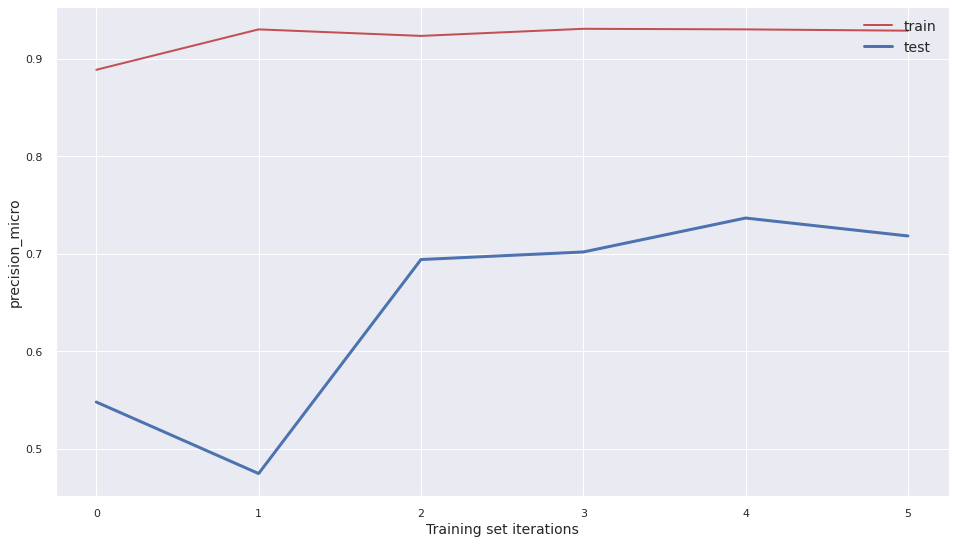

In [90]:
plot_learning_curves(prediction_pipeline, df_train, df_test, df_train_labels, df_test_labels, 200)

## Dataset of size 10000

In [106]:
importlib.reload(sys.modules['functions'])
from functions import *
importlib.reload(sys.modules['functions'])

<module 'functions' from '/home/francois/coding/OC/PJ6/functions.py'>

In [107]:
df_train = df_train_ori
df_test = df_test_ori

df_train_labels = df_train_labels_ori
df_test_labels = df_test_labels_ori

In [108]:
DATASET_SIZE = 10000
DATASET_TEST_SIZE = 1000

df_train = df_train.loc[0:DATASET_SIZE, :]
df_train_labels = df_train_labels.loc[0:DATASET_SIZE, :]

df_test = df_test.loc[0:DATASET_TEST_SIZE, :]
df_test_labels = df_test_labels.loc[0:DATASET_TEST_SIZE, :]

In [109]:
prediction_pipeline = Pipeline([
    ('doc2vec', Doc2Vec_Vectorizer(model_path=DOC2VEC_TRAINING_SAVE_FILE, feature_totransform='all_text')),
    #('features_selector', FeaturesSelector(features_toselect=['Tags'])),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(),)
    ])

Calculating learning curve for 6 iterations
Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


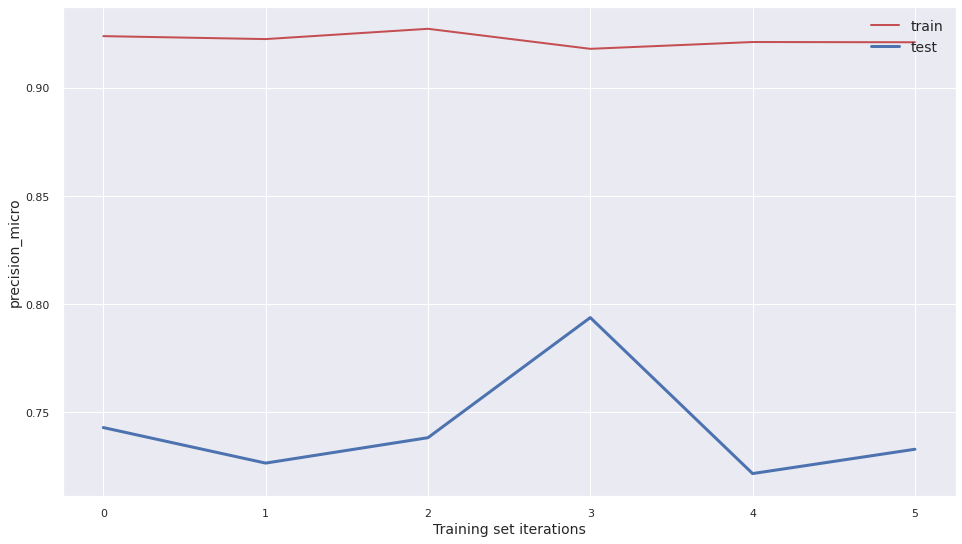

In [110]:
plot_learning_curves(prediction_pipeline, df_train, df_test, df_train_labels, df_test_labels, 2000)

## Dataset of size 100000

In [39]:
importlib.reload(sys.modules['functions'])
from functions import *
importlib.reload(sys.modules['functions'])

<module 'functions' from '/home/francois/coding/OC/PJ6/functions.py'>

In [40]:
df_train = df_train_ori
df_test = df_test_ori

df_train_labels = df_train_labels_ori
df_test_labels = df_test_labels_ori

In [41]:
DATASET_SIZE = 100000
DATASET_TEST_SIZE = 10000

df_train = df_train.loc[0:DATASET_SIZE-1, :]
df_train_labels = df_train_labels.loc[0:DATASET_SIZE-1, :]

df_test = df_test.loc[0:DATASET_TEST_SIZE-1, :]
df_test_labels = df_test_labels.loc[0:DATASET_TEST_SIZE-1, :]

In [42]:
prediction_pipeline = Pipeline([
    ('doc2vec', Doc2Vec_Vectorizer(model_path=DOC2VEC_TRAINING_SAVE_FILE, feature_totransform='all_text')),
    #('features_selector', FeaturesSelector(features_toselect=['Tags'])),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(),)
    ])

Calculating learning curve for 5 iterations
nb_instances_index: 100000)
5
Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Model fitted
Transform Doc2vec_Vectorizer
Infering new vectors


Transform Doc2vec_Vectorizer
Infering new vectors


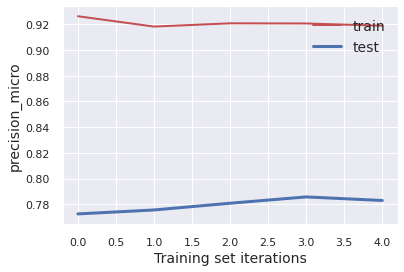

In [43]:
plot_learning_curves(prediction_pipeline, df_train, df_test, df_train_labels, df_test_labels, 20000)

# Implementation of a KNN classification algorithm on 90000 instances and check predictions

In [44]:
importlib.reload(sys.modules['functions'])
from functions import *

In [45]:
df_train = df_train_ori
df_test = df_test_ori

df_train_labels = df_train_labels_ori
df_test_labels = df_test_labels_ori

In [46]:
DATASET_SIZE = 90000
DATASET_TEST_SIZE = 10000

df_train = df_train.loc[0:DATASET_SIZE-1, :]
df_train_labels = df_train_labels.loc[0:DATASET_SIZE-1, :]

df_test = df_test.loc[0:DATASET_TEST_SIZE-1, :]
df_test_labels = df_test_labels.loc[0:DATASET_TEST_SIZE-1, :]

In [47]:
df_train

,index,Body,Title,all_text
0,38627,"Here is my code:\n def ping_host(self, host...",why is my ping command getting a usage error?,why is my ping command getting a usage error?....
1,287251,Gradle sync failed when the firebase cloud mes...,Gradle project sync failed. Basic functionalit...,Gradle project sync failed. Basic functionalit...
2,55807,"I have a panda dataframe with many rows, I am ...",Passing second argument to function in pool.map,Passing second argument to function in pool.ma...
3,21833,"I am doing a file upload page , that will rena...",move_uploaded_file() failed to open stream and...,move_uploaded_file() failed to open stream and...
4,174456,I have this piece of code located inside of th...,Using Router in an interceptor located in inde...,Using Router in an interceptor located in inde...
...,...,...,...,...
89995,238537,In my C# solution I have an assembly project c...,Using Two Assemblies One with Preprocessor Def...,Using Two Assemblies One with Preprocessor Def...
89996,162531,I want this program to be in a loop until the ...,while True python,while True python. I want this program to be i...
89997,115994,"I'm learning Python, but I am using 3.x, and t...",How to fix 'TypeError: %d format: a number is ...,How to fix 'TypeError: %d format: a number is ...
89998,168412,Can I specify a custom Java trust store for th...,Is it possible to use a custom Java trust stor...,Is it possible to use a custom Java trust stor...


In [48]:
prediction_pipeline = Pipeline([
    ('doc2vec', Doc2Vec_Vectorizer(model_path=DOC2VEC_TRAINING_SAVE_FILE, feature_totransform='all_text')),
    #('features_selector', FeaturesSelector(features_toselect=['Tags'])),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(),)
    ])

In [49]:
prediction_pipeline.fit(df_train, df_train_labels)

Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Infering new vectors


Pipeline(memory=None,
         steps=[('doc2vec',
                 Doc2Vec_Vectorizer(feature_totransform='all_text', min_count=5,
                                    model_path='doc2vec_model',
                                    model_save_path=None, n_dim=200,
                                    remove_stopwords=None, window=5)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [50]:
%%time
predictions_train = prediction_pipeline.predict(df_train)

Transform Doc2vec_Vectorizer
Infering new vectors


CPU times: user 1h 25min 16s, sys: 2min 27s, total: 1h 27min 43s
Wall time: 1h 27min 42s


In [51]:
df_predictions_train = pd.DataFrame(predictions_train, columns=df_train_labels.columns)

In [52]:
%%time
predictions_test = prediction_pipeline.predict(df_test)

Transform Doc2vec_Vectorizer
Infering new vectors


CPU times: user 8min 40s, sys: 527 ms, total: 8min 41s
Wall time: 8min 42s


In [53]:
df_predictions_test = pd.DataFrame(predictions_test, columns=df_test_labels.columns)

In [54]:
df_predictions_train

,Tags_.htaccess,Tags_.net,Tags_.net-core,Tags_ajax,Tags_algorithm,Tags_amazon-ec2,Tags_amazon-s3,Tags_amazon-web-services,Tags_anaconda,Tags_android,Tags_android-fragments,Tags_android-layout,Tags_android-recyclerview,Tags_android-studio,Tags_angular,Tags_angular-material,Tags_angular6,Tags_angular7,Tags_angularjs,Tags_animation,Tags_ansible,Tags_apache,Tags_apache-kafka,Tags_apache-spark,Tags_apache-spark-sql,Tags_api,Tags_arraylist,Tags_arrays,Tags_asp.net,Tags_asp.net-core,Tags_asp.net-core-mvc,Tags_asp.net-mvc,Tags_asp.net-web-api,Tags_assembly,Tags_async-await,Tags_asynchronous,Tags_authentication,Tags_automation,Tags_awk,Tags_aws-lambda,Tags_axios,Tags_azure,Tags_azure-active-directory,Tags_azure-devops,Tags_azure-functions,Tags_bash,Tags_batch-file,Tags_beautifulsoup,Tags_bootstrap-4,Tags_button,Tags_c,Tags_c#,Tags_c++,Tags_c++11,Tags_c++17,Tags_caching,Tags_canvas,Tags_class,Tags_cmake,Tags_cmd,Tags_codeigniter,Tags_cordova,Tags_css,Tags_csv,Tags_curl,Tags_d3.js,Tags_dart,Tags_data-structures,Tags_database,Tags_dataframe,Tags_datatable,Tags_datatables,Tags_date,Tags_datetime,Tags_debugging,Tags_deep-learning,Tags_delphi,Tags_dependency-injection,Tags_design-patterns,Tags_dictionary,Tags_django,Tags_django-forms,Tags_django-models,Tags_django-rest-framework,Tags_django-views,Tags_docker,Tags_docker-compose,Tags_dom,Tags_dplyr,Tags_eclipse,Tags_ecmascript-6,Tags_elasticsearch,Tags_electron,Tags_eloquent,Tags_email,Tags_encryption,Tags_entity-framework,Tags_entity-framework-core,Tags_excel,Tags_excel-formula,Tags_exception,Tags_expo,Tags_express,Tags_facebook,Tags_ffmpeg,Tags_file,Tags_filter,Tags_firebase,Tags_firebase-authentication,Tags_firebase-realtime-database,Tags_flask,Tags_flexbox,Tags_flutter,Tags_for-loop,Tags_forms,Tags_function,Tags_gcc,Tags_generics,Tags_ggplot2,Tags_git,Tags_github,Tags_gitlab,Tags_go,Tags_google-api,Tags_google-app-engine,Tags_google-apps-script,Tags_google-bigquery,Tags_google-chrome,Tags_google-chrome-extension,Tags_google-cloud-firestore,Tags_google-cloud-functions,Tags_google-cloud-platform,Tags_google-maps,Tags_google-sheets,Tags_gradle,Tags_graphql,Tags_groovy,Tags_group-by,Tags_hadoop,Tags_haskell,Tags_heroku,Tags_hibernate,Tags_highcharts,Tags_hive,Tags_html,Tags_http,Tags_https,Tags_if-statement,Tags_iis,Tags_image,Tags_image-processing,Tags_import,Tags_indexing,Tags_inheritance,Tags_input,Tags_intellij-idea,Tags_ionic-framework,Tags_ionic3,Tags_ionic4,Tags_ios,Tags_java,Tags_java-8,Tags_java-stream,Tags_javafx,Tags_javascript,Tags_jdbc,Tags_jenkins,Tags_jenkins-pipeline,Tags_jestjs,Tags_jmeter,Tags_join,Tags_jpa,Tags_jquery,Tags_json,Tags_junit,Tags_jupyter-notebook,Tags_jwt,Tags_keras,Tags_kotlin,Tags_kubernetes,Tags_lambda,Tags_laravel,Tags_laravel-5,Tags_laravel-5.7,Tags_linq,Tags_linux,Tags_list,Tags_listview,Tags_logging,Tags_loops,Tags_machine-learning,Tags_macos,Tags_mariadb,Tags_math,Tags_matlab,Tags_matplotlib,Tags_matrix,Tags_maven,Tags_memory,Tags_merge,Tags_model-view-controller,Tags_mongodb,Tags_mongoose,Tags_ms-access,Tags_multidimensional-array,Tags_multithreading,Tags_mvvm,Tags_mysql,Tags_mysqli,Tags_nativescript,Tags_neo4j,Tags_networking,Tags_neural-network,Tags_nginx,Tags_nlp,Tags_node.js,Tags_npm,Tags_numpy,Tags_oauth-2.0,Tags_object,Tags_objective-c,Tags_oop,Tags_opencv,Tags_opengl,Tags_optimization,Tags_oracle,Tags_outlook,Tags_pandas,Tags_pandas-groupby,Tags_parsing,Tags_pdf,Tags_performance,Tags_perl,Tags_php,Tags_pip,Tags_plot,Tags_plsql,Tags_pointers,Tags_post,Tags_postgresql,Tags_powerbi,Tags_powershell,Tags_promise,Tags_pycharm,Tags_pygame,Tags_pyqt5,Tags_pyspark,Tags_python,Tags_python-2.7,Tags_python-3.x,Tags_python-requests,Tags_pytorch,Tags_qt,Tags_r,Tags_random,Tags_razor,Tags_react-native,Tags_react-redux,Tags_react-router,Tags_reactjs,Tags_recursion,Tags_redis,Tags_redux,Tags_regex,Tags_rest,Tags_ruby,Tags_ruby-on-rails,Tags_ruby-on-rails-5,Tags_rust,Tags_rxjs,Tags_sass,Tags_scala,Tags_scikit-learn,Tags_scipy,Tags_scrapy,Tags_search,Tags_securit

In [55]:
df_predictions_test

,Tags_.htaccess,Tags_.net,Tags_.net-core,Tags_ajax,Tags_algorithm,Tags_amazon-ec2,Tags_amazon-s3,Tags_amazon-web-services,Tags_anaconda,Tags_android,Tags_android-fragments,Tags_android-layout,Tags_android-recyclerview,Tags_android-studio,Tags_angular,Tags_angular-material,Tags_angular6,Tags_angular7,Tags_angularjs,Tags_animation,Tags_ansible,Tags_apache,Tags_apache-kafka,Tags_apache-spark,Tags_apache-spark-sql,Tags_api,Tags_arraylist,Tags_arrays,Tags_asp.net,Tags_asp.net-core,Tags_asp.net-core-mvc,Tags_asp.net-mvc,Tags_asp.net-web-api,Tags_assembly,Tags_async-await,Tags_asynchronous,Tags_authentication,Tags_automation,Tags_awk,Tags_aws-lambda,Tags_axios,Tags_azure,Tags_azure-active-directory,Tags_azure-devops,Tags_azure-functions,Tags_bash,Tags_batch-file,Tags_beautifulsoup,Tags_bootstrap-4,Tags_button,Tags_c,Tags_c#,Tags_c++,Tags_c++11,Tags_c++17,Tags_caching,Tags_canvas,Tags_class,Tags_cmake,Tags_cmd,Tags_codeigniter,Tags_cordova,Tags_css,Tags_csv,Tags_curl,Tags_d3.js,Tags_dart,Tags_data-structures,Tags_database,Tags_dataframe,Tags_datatable,Tags_datatables,Tags_date,Tags_datetime,Tags_debugging,Tags_deep-learning,Tags_delphi,Tags_dependency-injection,Tags_design-patterns,Tags_dictionary,Tags_django,Tags_django-forms,Tags_django-models,Tags_django-rest-framework,Tags_django-views,Tags_docker,Tags_docker-compose,Tags_dom,Tags_dplyr,Tags_eclipse,Tags_ecmascript-6,Tags_elasticsearch,Tags_electron,Tags_eloquent,Tags_email,Tags_encryption,Tags_entity-framework,Tags_entity-framework-core,Tags_excel,Tags_excel-formula,Tags_exception,Tags_expo,Tags_express,Tags_facebook,Tags_ffmpeg,Tags_file,Tags_filter,Tags_firebase,Tags_firebase-authentication,Tags_firebase-realtime-database,Tags_flask,Tags_flexbox,Tags_flutter,Tags_for-loop,Tags_forms,Tags_function,Tags_gcc,Tags_generics,Tags_ggplot2,Tags_git,Tags_github,Tags_gitlab,Tags_go,Tags_google-api,Tags_google-app-engine,Tags_google-apps-script,Tags_google-bigquery,Tags_google-chrome,Tags_google-chrome-extension,Tags_google-cloud-firestore,Tags_google-cloud-functions,Tags_google-cloud-platform,Tags_google-maps,Tags_google-sheets,Tags_gradle,Tags_graphql,Tags_groovy,Tags_group-by,Tags_hadoop,Tags_haskell,Tags_heroku,Tags_hibernate,Tags_highcharts,Tags_hive,Tags_html,Tags_http,Tags_https,Tags_if-statement,Tags_iis,Tags_image,Tags_image-processing,Tags_import,Tags_indexing,Tags_inheritance,Tags_input,Tags_intellij-idea,Tags_ionic-framework,Tags_ionic3,Tags_ionic4,Tags_ios,Tags_java,Tags_java-8,Tags_java-stream,Tags_javafx,Tags_javascript,Tags_jdbc,Tags_jenkins,Tags_jenkins-pipeline,Tags_jestjs,Tags_jmeter,Tags_join,Tags_jpa,Tags_jquery,Tags_json,Tags_junit,Tags_jupyter-notebook,Tags_jwt,Tags_keras,Tags_kotlin,Tags_kubernetes,Tags_lambda,Tags_laravel,Tags_laravel-5,Tags_laravel-5.7,Tags_linq,Tags_linux,Tags_list,Tags_listview,Tags_logging,Tags_loops,Tags_machine-learning,Tags_macos,Tags_mariadb,Tags_math,Tags_matlab,Tags_matplotlib,Tags_matrix,Tags_maven,Tags_memory,Tags_merge,Tags_model-view-controller,Tags_mongodb,Tags_mongoose,Tags_ms-access,Tags_multidimensional-array,Tags_multithreading,Tags_mvvm,Tags_mysql,Tags_mysqli,Tags_nativescript,Tags_neo4j,Tags_networking,Tags_neural-network,Tags_nginx,Tags_nlp,Tags_node.js,Tags_npm,Tags_numpy,Tags_oauth-2.0,Tags_object,Tags_objective-c,Tags_oop,Tags_opencv,Tags_opengl,Tags_optimization,Tags_oracle,Tags_outlook,Tags_pandas,Tags_pandas-groupby,Tags_parsing,Tags_pdf,Tags_performance,Tags_perl,Tags_php,Tags_pip,Tags_plot,Tags_plsql,Tags_pointers,Tags_post,Tags_postgresql,Tags_powerbi,Tags_powershell,Tags_promise,Tags_pycharm,Tags_pygame,Tags_pyqt5,Tags_pyspark,Tags_python,Tags_python-2.7,Tags_python-3.x,Tags_python-requests,Tags_pytorch,Tags_qt,Tags_r,Tags_random,Tags_razor,Tags_react-native,Tags_react-redux,Tags_react-router,Tags_reactjs,Tags_recursion,Tags_redis,Tags_redux,Tags_regex,Tags_rest,Tags_ruby,Tags_ruby-on-rails,Tags_ruby-on-rails-5,Tags_rust,Tags_rxjs,Tags_sass,Tags_scala,Tags_scikit-learn,Tags_scipy,Tags_scrapy,Tags_search,Tags_securit

In [56]:
df_train

,index,Body,Title,all_text
0,38627,"Here is my code:\n def ping_host(self, host...",why is my ping command getting a usage error?,why is my ping command getting a usage error?....
1,287251,Gradle sync failed when the firebase cloud mes...,Gradle project sync failed. Basic functionalit...,Gradle project sync failed. Basic functionalit...
2,55807,"I have a panda dataframe with many rows, I am ...",Passing second argument to function in pool.map,Passing second argument to function in pool.ma...
3,21833,"I am doing a file upload page , that will rena...",move_uploaded_file() failed to open stream and...,move_uploaded_file() failed to open stream and...
4,174456,I have this piece of code located inside of th...,Using Router in an interceptor located in inde...,Using Router in an interceptor located in inde...
...,...,...,...,...
89995,238537,In my C# solution I have an assembly project c...,Using Two Assemblies One with Preprocessor Def...,Using Two Assemblies One with Preprocessor Def...
89996,162531,I want this program to be in a loop until the ...,while True python,while True python. I want this program to be i...
89997,115994,"I'm learning Python, but I am using 3.x, and t...",How to fix 'TypeError: %d format: a number is ...,How to fix 'TypeError: %d format: a number is ...
89998,168412,Can I specify a custom Java trust store for th...,Is it possible to use a custom Java trust stor...,Is it possible to use a custom Java trust stor...


## Performance measures

In [57]:
precision_score(df_train_labels, df_predictions_train, average='micro')

0.8467467236302754

In [58]:
precision_score(df_train_labels, df_predictions_train, average='macro')

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.



0.7957226526668505

In [59]:
# Shows exact matchs of all tags
accuracy_score(df_train_labels, df_predictions_train)

0.16293333333333335

In [60]:
recall_score(df_train_labels, df_predictions_train, average='micro')

0.17657929905248076

In [61]:
recall_score(df_train_labels, df_predictions_train, average='macro')

0.08575115399268679

In [67]:
roc_auc_score(df_train_labels, df_predictions_train)

0.560911087276714

In [62]:
precision_score(df_test_labels, df_predictions_test, average='micro')

0.6160438806993487

In [63]:
precision_score(df_test_labels, df_predictions_test, average='macro')

0.3062016447865273

In [64]:
# Shows exact matchs of all tags
accuracy_score(df_test_labels, df_predictions_test)

0.115

In [65]:
recall_score(df_test_labels, df_predictions_test, average='micro')

0.09745647811703455

In [66]:
recall_score(df_test_labels, df_predictions_test, average='macro')

0.04295798216338372

In [53]:
roc_auc_score(df_test_labels, df_predictions_test)

0.5245622063624816

In [54]:
predictions_test.shape

(29915, 357)

## Check how many instances have at least 1 tag predicted

In [73]:
df_test_labels_sum = df_test_labels.sum(axis=1)

In [76]:
df_test_labels_sum.shape

(10000,)

In [77]:
df_test_labels_sum[df_test_labels_sum > 0]

0       2
1       3
2       1
3       2
4       3
       ..
9995    2
9996    1
9997    2
9998    1
9999    1
Length: 9165, dtype: int64

=> 90% of instances have at least 1 predicted class to true (61% precision on them)

## Number of instances per class

In [87]:
pd.set_option('display.max_rows', 400)
df_train_labels.sum().sort_values(ascending=False)

Tags_python                        10248
Tags_javascript                     9422
Tags_java                           6628
Tags_c#                             5298
Tags_php                            4526
Tags_android                        4501
Tags_html                           3907
Tags_python-3.x                     2747
Tags_reactjs                        2646
Tags_angular                        2645
Tags_sql                            2548
Tags_css                            2546
Tags_r                              2457
Tags_node.js                        2370
Tags_c++                            2359
Tags_mysql                          2136
Tags_jquery                         2046
Tags_swift                          1747
Tags_pandas                         1729
Tags_ios                            1709
Tags_arrays                         1563
Tags_excel                          1498
Tags_sql-server                     1438
Tags_django                         1431
Tags_typescript 

In [97]:
df_test_labels.sum().sort_values(ascending=False)

Tags_python                        1200
Tags_javascript                    1010
Tags_java                           735
Tags_c#                             548
Tags_android                        504
Tags_php                            472
Tags_html                           446
Tags_python-3.x                     368
Tags_angular                        313
Tags_css                            297
Tags_reactjs                        297
Tags_node.js                        291
Tags_sql                            275
Tags_mysql                          264
Tags_r                              259
Tags_c++                            237
Tags_jquery                         221
Tags_swift                          203
Tags_pandas                         196
Tags_ios                            192
Tags_json                           178
Tags_excel                          169
Tags_typescript                     161
Tags_arrays                         160
Tags_sql-server                     158


## Score per class

In [96]:
from sklearn.metrics import classification_report

print(classification_report(df_test_labels, df_predictions_test, target_names=df_test_labels.columns.tolist()))

                                 precision    recall  f1-score   support

                 Tags_.htaccess       0.00      0.00      0.00        18
                      Tags_.net       1.00      0.01      0.02        90
                 Tags_.net-core       0.00      0.00      0.00        46
                      Tags_ajax       0.00      0.00      0.00        63
                 Tags_algorithm       0.00      0.00      0.00        30
                Tags_amazon-ec2       1.00      0.12      0.21        17
                 Tags_amazon-s3       0.00      0.00      0.00        21
       Tags_amazon-web-services       0.64      0.10      0.17        70
                  Tags_anaconda       0.67      0.13      0.22        15
                   Tags_android       0.73      0.31      0.44       504
         Tags_android-fragments       0.67      0.14      0.24        14
            Tags_android-layout       0.00      0.00      0.00        18
      Tags_android-recyclerview       0.00      0.

In [118]:
pd.DataFrame(classification_report(df_train_labels, df_predictions_train, target_names=df_train_labels.columns.tolist(), output_dict=True)).transpose()\
    .sort_values(by='precision', ascending=False).shape

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.



(361, 4)

In [112]:
pd.DataFrame(classification_report(df_train_labels, df_predictions_train, target_names=df_train_labels.columns.tolist(), output_dict=True)).transpose()\
    .sort_values(by='precision', ascending=False)

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.



,precision,recall,f1-score,support
Tags_nlp,1.000000,0.034483,0.066667,87.0
Tags_redis,1.000000,0.095238,0.173913,84.0
Tags_iis,1.000000,0.009091,0.018018,110.0
Tags_scipy,1.000000,0.025641,0.050000,78.0
Tags_image-processing,1.000000,0.050725,0.096552,138.0
Tags_inheritance,1.000000,0.009346,0.018519,107.0
Tags_input,1.000000,0.015625,0.030769,128.0
Tags_dependency-injection,1.000000,0.039604,0.076190,101.0
Tags_variables,1.000000,0.005814,0.011561,172.0
Tags_security,1.000000,0.008264,0.016393,121.0


=> La majorité des classes sont au dessus de 70% de précision

In [117]:
pd.DataFrame(classification_report(df_test_labels, df_predictions_test, target_names=df_test_labels.columns.tolist(), output_dict=True)).transpose()\
    .sort_values(by='precision', ascending=False)

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.



,precision,recall,f1-score,support
Tags_flexbox,1.000000,0.071429,0.133333,14.0
Tags_encryption,1.000000,0.230769,0.375000,13.0
Tags_google-cloud-firestore,1.000000,0.166667,0.285714,36.0
Tags_google-apps-script,1.000000,0.071429,0.133333,28.0
Tags_shiny,1.000000,0.117647,0.210526,17.0
Tags_socket.io,1.000000,0.090909,0.166667,11.0
Tags_sockets,1.000000,0.045455,0.086957,22.0
Tags_flutter,1.000000,0.187500,0.315789,80.0
Tags_firebase-realtime-database,1.000000,0.040000,0.076923,25.0
Tags_express,1.000000,0.030769,0.059701,65.0


=> Overfit :  
Tags_python 	0.535714 	0.300000 	0.384615 	1200.0

## Number of correct labels predicted per sample

In [126]:
df_train_nb_correct_labels_predicted = (df_train_labels * df_predictions_train).sum(axis=1)

In [128]:
df_train_nb_correct_labels_predicted[df_train_nb_correct_labels_predicted > 0]

2        1
3        1
4        1
6        2
9        2
        ..
89979    2
89984    1
89989    1
89994    1
89997    1
Length: 23866, dtype: int64

In [122]:
df_test_nb_correct_labels_predicted = (df_test_labels * df_predictions_test).sum(axis=1)

In [124]:
df_test_nb_correct_labels_predicted[df_test_nb_correct_labels_predicted > 0]

7       1
10      1
29      1
50      1
64      1
       ..
9970    1
9972    2
9979    3
9996    1
9997    1
Length: 1568, dtype: int64

In [125]:
df_test_nb_correct_labels_predicted

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    1
9997    1
9998    0
9999    0
Length: 10000, dtype: int64

In [139]:
df_train_nb_correct_labels_predicted[df_train_nb_correct_labels_predicted == 0]

0        0
1        0
5        0
7        0
8        0
        ..
89993    0
89995    0
89996    0
89998    0
89999    0
Length: 66134, dtype: int64

In [136]:
index_train_noclue = df_train_nb_correct_labels_predicted[df_train_nb_correct_labels_predicted == 0].index

In [137]:
index_train_noclue

Int64Index([    0,     1,     5,     7,     8,    11,    12,    13,    14,
               16,
            ...
            89987, 89988, 89990, 89991, 89992, 89993, 89995, 89996, 89998,
            89999],
           dtype='int64', length=66134)

In [138]:
df_train.loc[index_train_noclue, :]

,index,Body,Title,all_text
0,38627,"Here is my code:\n def ping_host(self, host...",why is my ping command getting a usage error?,why is my ping command getting a usage error?....
1,287251,Gradle sync failed when the firebase cloud mes...,Gradle project sync failed. Basic functionalit...,Gradle project sync failed. Basic functionalit...
5,92709,I'm binding a click event to an element (butto...,Why binding the new click event delays the cur...,Why binding the new click event delays the cur...
7,238821,"I was given a web form, which show the product...",How to use repeater with ArrayList multiple va...,How to use repeater with ArrayList multiple va...
8,220052,I have a dictionary in which the key is a coun...,How do I determine which dictionary has the mo...,How do I determine which dictionary has the mo...
...,...,...,...,...
89993,189351,I want to replace a single element of a list w...,Selectively modify single element of a list in...,Selectively modify single element of a list in...
89995,238537,In my C# solution I have an assembly project c...,Using Two Assemblies One with Preprocessor Def...,Using Two Assemblies One with Preprocessor Def...
89996,162531,I want this program to be in a loop until the ...,while True python,while True python. I want this program to be i...
89998,168412,Can I specify a custom Java trust store for th...,Is it possible to use a custom Java trust stor...,Is it possible to use a custom Java trust stor...


In [141]:
doc_index = 0
col_names_tags_value_1 = [col for col in df_train_labels[df_predictions_train.index.isin([doc_index])]\
                          if (df_predictions_train[df_train_labels.index.isin([doc_index])][col] == 1).any()]

In [ ]:
# Labels that model had no clue to predict (all labels that were missed, plus the model missed all of the other labels for the instance)
col_names_tags_value_1_labels = [[col for col in df_train_labels[df_predictions_train.index.isin([doc_index])]\
                        if (df_train_labels[df_train_labels.index.isin([doc_index])][col] == 1).any()]  for doc_index in index_train_noclue]

In [147]:
col_names_tags_value_1_labels

['Tags_python']

In [143]:
'''
#Too slow
col_names_tags_value_1_allsamples = [[col for col in df_train_labels[df_predictions_train.index.isin([doc_index])]\
                          if (df_predictions_train[df_train_labels.index.isin([doc_index])][col] == 1).any()] for doc_index in index_train_noclue]

'''

KeyboardInterrupt: 

In [142]:
col_names_tags_value_1

[]

In [ ]:
df_predictions_test

In [116]:
df_predictions_train['Tags_electron'].sum()

0

In [104]:
print(classification_report(df_train_labels, df_predictions_train, target_names=df_train_labels.columns.tolist()))

                                 precision    recall  f1-score   support

                 Tags_.htaccess       0.90      0.11      0.19       178
                      Tags_.net       0.75      0.01      0.02       762
                 Tags_.net-core       0.75      0.02      0.05       370
                      Tags_ajax       0.87      0.04      0.08       593
                 Tags_algorithm       0.82      0.06      0.12       365
                Tags_amazon-ec2       0.57      0.02      0.04       171
                 Tags_amazon-s3       0.92      0.09      0.17       257
       Tags_amazon-web-services       0.84      0.12      0.22       868
                  Tags_anaconda       0.88      0.12      0.22       114
                   Tags_android       0.89      0.43      0.58      4501
         Tags_android-fragments       0.75      0.36      0.49       157
            Tags_android-layout       1.00      0.04      0.08       159
      Tags_android-recyclerview       0.89      0.

## Precision / Recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(prediction_pipeline, df_test, df_test_labels)

# Implementation of a Decision Tree classification algorithm

In [58]:
importlib.reload(sys.modules['functions'])
from functions import *

In [59]:
df_train = df_train_ori
df_test = df_test_ori

df_train_labels = df_train_labels_ori
df_test_labels = df_test_labels_ori

In [60]:
DATASET_SIZE = 90000
DATASET_TEST_SIZE = 10000

df_train = df_train.loc[0:DATASET_SIZE-1, :]
df_train_labels = df_train_labels.loc[0:DATASET_SIZE-1, :]

df_test = df_test.loc[0:DATASET_TEST_SIZE-1, :]
df_test_labels = df_test_labels.loc[0:DATASET_TEST_SIZE-1, :]

'\ndf_train = df_train.loc[0:1000, :]\ndf_train_labels = df_train_labels.loc[0:1000, :]\n'

In [61]:
df_train

,index,Body,Title,all_text
0,38627,"Here is my code:\n def ping_host(self, host...",why is my ping command getting a usage error?,why is my ping command getting a usage error?....
1,287251,Gradle sync failed when the firebase cloud mes...,Gradle project sync failed. Basic functionalit...,Gradle project sync failed. Basic functionalit...
2,55807,"I have a panda dataframe with many rows, I am ...",Passing second argument to function in pool.map,Passing second argument to function in pool.ma...
3,21833,"I am doing a file upload page , that will rena...",move_uploaded_file() failed to open stream and...,move_uploaded_file() failed to open stream and...
4,174456,I have this piece of code located inside of th...,Using Router in an interceptor located in inde...,Using Router in an interceptor located in inde...
...,...,...,...,...
269224,120265,Can we get keys of a JSON in the same order it...,Get keys of object in order?,Get keys of object in order?. Can we get keys ...
269225,259932,I am using a rich text editor to type formatte...,Passing HTML string to my controller action me...,Passing HTML string to my controller action me...
269226,132354,Problem\nHow do I pass a value from a release ...,Setting and using an environment variable in m...,Setting and using an environment variable in m...
269227,147325,"I have a C programming exam a few days later, ...","Bitwise Operators in C, int 021 vs 21?","Bitwise Operators in C, int 021 vs 21?. I have..."


In [62]:
prediction_pipeline = Pipeline([
    ('doc2vec', Doc2Vec_Vectorizer(model_path=DOC2VEC_TRAINING_SAVE_FILE, feature_totransform='all_text')),
    #('features_selector', FeaturesSelector(features_toselect=['Tags'])),
    ('scaler', StandardScaler()),
    ('knn', DecisionTreeClassifier(),)
    ])

In [ ]:
%%time
prediction_pipeline.fit(df_train, df_train_labels)

Fit Doc2vec_Vectorizer
Transform Doc2vec_Vectorizer
Returning stored vectors from training set


In [ ]:
%%time
predictions_train = prediction_pipeline.predict(df_train)

In [ ]:
%%time
df_predictions_train = pd.DataFrame(predictions_train, columns=df_train_labels.columns)

In [ ]:
%%time
predictions_test = prediction_pipeline.predict(df_test)

In [ ]:
df_predictions_test = pd.DataFrame(predictions_test, columns=df_test_labels.columns)

In [ ]:
df_predictions_train

In [ ]:
df_predictions_test

In [ ]:
df_train

## Performance measures

In [ ]:
precision_score(df_train_labels, df_predictions_train, average='micro')

In [ ]:
precision_score(df_train_labels, df_predictions_train, average='macro')

In [ ]:
# Shows exact matchs of all tags
accuracy_score(df_train_labels, df_predictions_train)

In [ ]:
recall_score(df_train_labels, df_predictions_train, average='micro')

In [ ]:
recall_score(df_train_labels, df_predictions_train, average='macro')

In [ ]:
roc_auc_score(df_train_labels, df_predictions_train)

In [ ]:
precision_score(df_test_labels, df_predictions_test, average='micro')

In [ ]:
precision_score(df_test_labels, df_predictions_test, average='macro')

In [ ]:
# Shows exact matchs of all tags
accuracy_score(df_test_labels, df_predictions_test)

In [ ]:
recall_score(df_test_labels, df_predictions_test, average='micro')

In [ ]:
recall_score(df_test_labels, df_predictions_test, average='macro')

In [ ]:
roc_auc_score(df_test_labels, df_predictions_test)

In [ ]:
predictions_test.shape

# Annex (old code)

## Remove html tags in Body, and regroup Body + title

In [82]:
dataprep = PrepareTextData()

In [83]:
df = dataprep.fit_transform(df)

## Or with beautifulsoup
df.loc[:, 'Body'] = df['Body'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

In [93]:
pd.set_option('display.max_colwidth', None)
print(df.loc[45000]['all_text'])

How to get the name of the current file, module, and procedure in Chapel. In Chapel, is it possible to get the name of the current file, module, or procedure by some means (e.g., via a helper function)? My goal here is to print the routine name without writing it explicitly by hand in writeln().
proc calculate_this_and_that_ver2() {
  // writeln( "In calculate_this_and_that_ver2()" ); // long...
  writeln( "In ", modname(), " : ", procname() );
  ...
}

What I wish here may be similar to something like #function etc in Swift:
func mytest() {
   print( "file =", #file, "func =", #function, "line =", #line )
}
mytest()  // --> file = test.swift func = mytest() line = 2




In [10]:
# Converting tags from <tag 1><tag2><tag3> to tag1 tag2 tag3
df.loc[:, 'Tags'] = df['Tags'].str.replace('<', '') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.replace('>', ' ') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.rstrip()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149323 entries, 0 to 299998
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Body    149323 non-null  object
 1   Title   149323 non-null  object
 2   Tags    149323 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB


In [12]:
df.sample(100)

,Body,Title,Tags
193620,require(mlbench)\nrequire(e1071)\nrequire (car...,weight in extend caret random forest,r random-forest r-caret hyperparameters
127572,IntelliJ Idea 2020.1 shows this error for matH...,IntelliJ IDEA shows error for matHeaderRowDef,angular intellij-idea angular-material angular...
262111,"Need some Help With Typescript, React and Redu...","Typescript, React and Redux axios Error - acti...",javascript reactjs typescript redux
6013,I have a dataframe in which one column has tex...,How to add new Dataframe Column with Dictionar...,python pandas dictionary
45303,"I am trying to install RQDA to my RStudio, but...","Rstudio (RQDA error), gWidgetsRGtk2 cannot be ...",rstudio gwidgets rqda
207996,I have an issue where I cannot encode values t...,How to convert to Hungarian on Python,python encoding character-encoding
229763,I can not understand why this is not working i...,Simple Loop in python3 shell (version 3.81) Sy...,python-3.x
286484,I am working on finetunning a ResNet50 Net tha...,"Why using Softmax in a ""Finetunning Multioutpu...",keras deep-learning computer-vision resnet fin...
85208,System just updated to Transmission 3.0. Thin...,Transmission 3.0 update (Ubuntu 16.04) - using...,ubuntu-16.04 transmission-daemon
21227,I'm new to Dart 2. I want a class to have a pr...,What is an equivalent for Dart 2 to `typeof` o...,dart dart-2


## Regroup text features and clean

df.loc[:, 'Title'].fillna(value='', inplace=True)

df['all_text'] = df['Title'].astype(str) + '. ' +  df['Body'].astype(str)

## Split training set, test set (old)

In [104]:
df, df_train, df_test = custom_train_test_split_sample(df, None)

In [105]:
df_train.reset_index(drop=True, inplace=True)

In [106]:
df_train

,Body,Title,Tags
0,"<p>Here is my code:</p>\n\n<pre><code> def ping_host(self, hostname, ping_cmd='/usr/bin/ping', count=1, timeout=400):\n cmd = [ping_cmd, '-c%s' % count, '-W%s' % timeout, hostname]\n (output, error) = subprocess.Popen(cmd,\n stdout=subprocess.PIPE,\n stderr=subprocess.PIPE,\n shell=True).communicate()\n print ' '.join( cmd )\n print output, error\n</code></pre>\n\n<p>When I run it I get this output:</p>\n\n<pre><code>/usr/bin/ping -c1 -W400 tools-dev1.example.com\n Usage: ping [-aAbBdDfhLnOqrRUvV64] [-c count] [-i interval] [-I interface]\n [-m mark] [-M pmtudisc_option] [-l preload] [-p pattern] [-Q tos]\n [-s packetsize] [-S sndbuf] [-t ttl] [-T timestamp_option]\n [-w deadline] [-W timeout] [hop1 ...] destination\nUsage: ping -6 [-aAbBdDfhLnOqrRUvV] [-c count] [-i interval] [-I interface]\n [-l preload] [-m mark] [-M pmtudisc_option]\n [-N nodeinfo_option] [-p pattern] [-Q tclass] [-s packetsize]\n [-S sndbuf] [-t ttl] [-T timestamp_option] [-w deadline]\n [-W timeout] destination\n</code></pre>\n\n<p>I assume I am doing something wrong with the first argument, <code>cmd</code>, I am passing to <code>Popen()</code>, but I don't know what. If I cut-n-paste <code>/usr/bin/ping -c1 -W400 tools-dev1.example.com</code> to a command line it works fine.</p>\n",why is my ping command getting a usage error?,<python>
1,"<p>Gradle sync failed when the firebase cloud messaging dependency was applied.</p>\n\n<p>I've tried all the versions of FCM in app like 17.0.0, 17.3.2, 15.0.0, 16.0.1, etc. </p>\n\n<p><img src=""https://i.stack.imgur.com/NlK4f.png"" alt=""enter image description here""></p>\n\n<p><img src=""https://i.stack.imgur.com/a8A7F.png"" alt=""enter image description here""></p>\n\n<p><img src=""https://i.stack.imgur.com/XSQOh.png"" alt=""enter image description here""></p>\n","Gradle project sync failed. Basic functionality (e.g. editing, deugging ) will not work properly",<java><android><gradle><android-studio-3.2>
2,"<p>I have a panda dataframe with many rows, I am using multiprocessing to process grouped tables from this dataframe concurrently. It works fine but I have a problem passing in a second parameter, I have tried to pass both arguments as a Tuple but it doesn't work. My code is as follows:</p>\n\n<p>I want to also pass in the parameter ""col"" to the function ""process_table""</p>\n\n<pre><code>for col in cols:\n tables = df.groupby('test')\n p = Pool()\n lines = p.map(process_table, table)\n p.close()\n p.join()\n\ndef process_table(t):\n # Bunch of processing to create a line for matplotlib\n return line\n</code></pre>\n",Passing second argument to function in pool.map,<python><python-2.7><arguments><multiprocessing><python-multiprocessing>
3,"<p>I am doing a file upload page , that will rename the file before adding it , and i am getting those errors.\nI've tried <code>chmod -R 777 ./</code> in the folder of the website but it still doesn't work.</p>\n\n<pre><code> $dir = Users::currentUser()-&gt;id;//each user have his folder\nif(move_uploaded_file($_FILES[""file""][""tmp_name""], PROOT . 'files' . DS . $dir . DS))\n {\n echo ""The file has been uploaded as "".$ran2.$ext;\n //Router::redirect('upload');\n }\n else\n {\n echo ""Sorry, there was a problem uploading your file."";\n }\n</code></pre>\n\n<p>The <code>PROOT</code> is defined by me as the website root folder <code>define('PROOT','/framework/');</code> and the <code>DS</code> is the separator <code>(strtoupper(substr(PHP_OS, 0, 3)) === 'WIN') ? define('DS', '/') : define('DS', DIRECTORY_SEPARATOR);</code>.</p>\n\n<p>And this is how the error looks</p>\n\n<pre><code>Warning: move_uploaded_file(/framework/files/4/): failed to open stream: No such file or directory in /opt/lampp/htdocs/framework/app/controllers/UploadController.php on line 46\n\n\nWarning: move_uploaded_file(): Unable to move '/opt/lampp/temp/phpHz70FG' to '/framework/files/4/' in /opt/lampp/htdocs/framework/app/controllers/UploadController.php on line 46\n</code></pre

In [107]:
df_test

,Body,Title,Tags
141549,"<p>I am unable to figure out how to get to my landing page while running <code>node --inspect app.js</code>? For example, when I run it locally I would normally go to localhost:3000.</p>\n\n<p>It is not exactly clear to me how to get both going. My output with node is as follows: </p>\n\n<pre><code>C:\Users\user\Desktop\app&gt;node --inspect app.js\nDebugger listening on ws://127.0.0.1:9229/1e900a59-bd94-486c-9eee-\nd3be90717377\nFor help, see: https://nodejs.org/en/docs/inspector\n// more output\n</code></pre>\n\n<p>After I get the Devtools running using NiM, where do I go from there? </p>\n\n<p>Thank you,</p>\n",How to load website and debug node application?,<node.js><debugging><google-chrome-devtools>
227939,"<p>Authenticate is okay when the user info is correct but upon entering wrong details the server crashes </p>\n\n<pre><code>passport.use(new LocalStrategy({\n usernameField: 'password',\n passportField: 'username'\n},\n function(username, password, done) {\n con.query(""SELECT * FROM uids WHERE list ="" +""'"" + username + ""'"", function (err, result) {\n if (err) done(err);\n var clean = JSON.parse(JSON.stringify(result))[0].list //Expected Result : test2\n //from [ RowDataPacket { list: 'test2' } ]\n\n //no user was found\n\n if(username === clean) {\n //Success\n return done(null, true);\n } else {\n //Wrong password\n return done(null, false);\n }\n });\n }\n ));\n</code></pre>\n\n<p>Error From server:</p>\n\n<pre><code> throw err; // Rethrow non-MySQL errors\n ^\n\nTypeError: Cannot read property 'list' of undefined\n</code></pre>\n\n<p>I understand what is wrong but i dont know if there is a function to check if the list even exists </p>\n\n<pre><code>var mysql = require('mysql');\n\nvar con = mysql.createConnection({\n host: ""localhost"",\n user: ""dawg111"",\n password: ""poopingboy111"",\n database: ""mydb""\n});\n\ncon.connect(function(err) {\n if (err) throw err;\n console.log(""Connection to Database is ok!"");\n});\n\nconst LocalStrategy = require('passport-local').Strategy;\npassport.use(new LocalStrategy({\n usernameField: 'username',\n passportField: 'password'\n},\n function(username, password, done) {\n con.query('SELECT * FROM uids WHERE list = ?', [username], function (error, results, fields) {\n if (error) throw error;\n console.log(results);\n });\n }\n ));\n</code></pre>\n",How to fix unwanted exceptions from JSON.parse() commands,<javascript><mysql><node.js><passport.js>
263961,"<pre><code>dict = {'a':['b1','b2', 'b3'], 'b':['b1','b2','b3'], 'c':['b1','b3','b4','b5']}\ntoList = list(dict.values())\nos.path.commonprefix(toList)\n</code></pre>\n\n<p>os.path.commonprefix(toList) prints just ['b1'] but I'm trying to find the longest common prefix amongst any of the list of lists inputted, so ['b1', 'b2'] here. Another example:</p>\n\n<p>[a,b,c],[a,c,c],[a,b] -> [a,b]</p>\n\n<p>[a,c,d],[a,b,c],[a,d] -> [a]</p>\n\n<hr>\n\n<p>*EDITED ORIGINAL QUESTION - realized os.path.commonprefix(toList) doesn't return any existing common prefix (like in my example), but the common prefix of all given lists inputted. Is there a library that does do what I want in my example?</p>\n",Library like os.path.commonprefix but returns common prefix of any 2+ inputted lists?,<python><prefix><os.path>
199225,"<p>Suppose I randomly generate a list. </p>\n\n<pre><code>mylist = []\nfor i in range(0,10):\n s = np.random.choice([-1,0,1])\n mylist.append(s)\n</code></pre>\n\n<p>Now <code>for x in range(0,100)</code>. I modify the elements according to some rules, and then count the number of elements of each type, using <code>counts = Counter(mylist)</code></p>\n\n<pre><code>for x in range(0,100):\n #some rules\n counts = Counter[mylist]\n</code></pre>\n\n<p>In the beginning the list can be in a state when say the number of -1 is greater than the number of +1's, and then transition from state where the number of +1's is greater than the number of -1's. </p>\n\n<p>Is there way to count the number of times

In [108]:
df_test.reset_index(drop=True, inplace=True)

df['all_text']